## Python Imports

This Jupyter Notebook is implemented in Python v. 3.8 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import multiprocessing as mp
import seaborn as sns
import pandas as pd
import numpy as np
import pygmo as pg
import os
import time
from numba import jit
from scipy.stats import norm
from datetime import timedelta
from functools import partial
from itertools import chain, combinations

In [3]:
# Imports from FinanceOps.
import diversify
from portfolio_utils import (normalize_weights, weighted_returns,
    fix_correlation_matrix, check_correlation_matrix)
from returns import max_drawdown, max_pullup
from stats import normal_prob_loss, normal_prob_less_than
from utils import linear_map

In [4]:
# Imports from SimFin.
import simfin as sf
from simfin.names import (TOTAL_RETURN, CLOSE, VOLUME, TICKER,
                          PSALES, DATE)
from simfin.utils import BDAYS_PER_YEAR

## Config

In [5]:
# Random number generator.
# The seed makes the experiments repeatable. In the year 1965
# the scientist Richard Feynman was awarded the Nobel prize in
# physics for discovering that this particular number was the cause
# of "The Big Bang" and all that matters in the entire universe.
rng = np.random.default_rng(seed=81680085)

In [6]:
# Create directory for plots if it does not exist already.
path_plots = 'plots/portfolio_optimization/'
if not os.path.exists(path_plots):
    os.makedirs(path_plots)

In [7]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [8]:
# Matplotlib settings.
# Don't write e.g. +1 on top of the y-axis in some plots.
mpl.rcParams['axes.formatter.useoffset'] = False

# Used to format numbers on plot-axis as percentages.
pct_formatter0 = FuncFormatter(lambda x, _: '{:.0%}'.format(x))
pct_formatter1 = FuncFormatter(lambda x, _: '{:.1%}'.format(x))

# Used to format numbers on plot-axis in scientific notation.
sci_formatter0 = FuncFormatter(lambda x, _: '{:.0e}'.format(x))
sci_formatter1 = FuncFormatter(lambda x, _: '{:.1e}'.format(x))

In [9]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

In [10]:
# Plot-sizes.
figsize_small = (10, 4)
figsize_mid = (10, 8)
figsize_big = (10, 12)

## Helper Functions

In [11]:
def one_period_returns(prices, future):
    """
    Calculate the one-period return for the given share-prices.
    
    Note that these have 1.0 added so e.g. 1.05 means a one-period
    gain of 5% and 0.98 means a -2% loss.

    :param prices:
        Pandas DataFrame with e.g. daily stock-prices.
        
    :param future:
        Boolean whether to calculate the future returns (True)
        or the past returns (False).
        
    :return:
        Pandas DataFrame with one-period returns.
    """
    # One-period returns plus 1.
    rets = prices.pct_change(periods=1) + 1.0
    
    # Shift 1 time-step if we want future instead of past returns.
    if future:
        rets = rets.shift(-1)

    return rets

## Load and Process Daily Data

Use daily share-prices from the SimFin database. It should be fairly easy to replace this with another data-source.

In [12]:
%%time
# Use our custom version of the SimFin stock-hub to load data.
hub = sf.StockHub(market='us', refresh_days_shareprices=100)

# Download and load the daily share-prices for US stocks.
df_daily_prices = hub.load_shareprices(variant='daily')

Dataset "us-shareprices-daily" on disk (31 days old).
- Loading from disk ... Done!
CPU times: user 26.5 s, sys: 1.17 s, total: 27.7 s
Wall time: 28.2 s


In [13]:
%%time
# Calculate valuation signals such as P/Sales.
# Automatically downloads the required financial statements.
df_val_signals = hub.val_signals()

Dataset "us-income-ttm" on disk (24 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (24 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (24 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-77ca1f39.pickle' on disk (24 days old).
- Loading from disk ... Done!
CPU times: user 2.39 s, sys: 600 ms, total: 2.99 s
Wall time: 3.77 s


In [14]:
# Use the daily "Total Return" series which is the stock-price
# adjusted for stock-splits and reinvestment of dividends.
# This is a Pandas DataFrame in matrix-form where the rows are
# time-steps and the columns are for the individual stock-tickers.
daily_prices = df_daily_prices[TOTAL_RETURN].unstack().T

# Remove rows that have very little data. Sometimes this dataset
# has "phantom" data-points for a few stocks e.g. on weekends.
num_stocks = len(daily_prices.columns)
daily_prices = daily_prices.dropna(thresh=int(0.1 * num_stocks))

# Remove the last row because sometimes it is incomplete.
daily_prices = daily_prices.iloc[0:-1]

# Show it.
daily_prices.head()

Ticker          A  AA    AAL  AAMC  AAME  AAN  AAOI  AAON    AAP  AAPL  ...  \
Date                                                                    ...   
2007-01-03  22.66 NaN  53.07   NaN  2.80  NaN   NaN  4.50  33.57  2.57  ...   
2007-01-04  22.73 NaN  55.46   NaN  2.86  NaN   NaN  4.55  33.79  2.63  ...   
2007-01-05  22.52 NaN  54.94   NaN  3.14  NaN   NaN  4.43  33.05  2.61  ...   
2007-01-08  22.44 NaN  54.60   NaN  3.30  NaN   NaN  4.48  33.16  2.62  ...   
2007-01-09  22.47 NaN  54.58   NaN  3.34  NaN   NaN  4.49  33.44  2.84  ...   

Ticker      ZNGA  ZOM  ZS  ZTS   ZUMZ  ZUO  ZVO  ZY  ZYNE  ZYXI  
Date                                                             
2007-01-03   NaN  NaN NaN  NaN  31.05  NaN  NaN NaN   NaN  0.18  
2007-01-04   NaN  NaN NaN  NaN  32.44  NaN  NaN NaN   NaN  0.18  
2007-01-05   NaN  NaN NaN  NaN  32.57  NaN  NaN NaN   NaN  0.22  
2007-01-08   NaN  NaN NaN  NaN  32.95  NaN  NaN NaN   NaN  0.22  
2007-01-09   NaN  NaN NaN  NaN  33.94  NaN  NaN NaN   NaN  0.22  

[5 rows x 2708 columns]

In [15]:
# Daily stock-returns calculated from the "Total Return".
# We could have used SimFin's function hub.returns() but
# this code makes it easier for you to use another data-source.
# This is a Pandas DataFrame in matrix-form where the rows are
# time-steps and the columns are for the individual tickers.
daily_returns_all = one_period_returns(prices=daily_prices, future=True)

# Remove empty rows (this should only be the first row).
daily_returns_all = daily_returns_all.dropna(how='all')

# Show it.
daily_returns_all.head()

Ticker             A  AA       AAL  AAMC      AAME  AAN  AAOI      AAON  \
Date                                                                      
2007-01-03  1.003089 NaN  1.045035   NaN  1.021429  NaN   NaN  1.011111   
2007-01-04  0.990761 NaN  0.990624   NaN  1.097902  NaN   NaN  0.973626   
2007-01-05  0.996448 NaN  0.993811   NaN  1.050955  NaN   NaN  1.011287   
2007-01-08  1.001337 NaN  0.999634   NaN  1.012121  NaN   NaN  1.002232   
2007-01-09  0.990654 NaN  1.017772   NaN  1.020958  NaN   NaN  0.997773   

Ticker           AAP      AAPL  ...  ZNGA  ZOM  ZS  ZTS      ZUMZ  ZUO  ZVO  \
Date                            ...                                           
2007-01-03  1.006553  1.023346  ...   NaN  NaN NaN  NaN  1.044767  NaN  NaN   
2007-01-04  0.978100  0.992395  ...   NaN  NaN NaN  NaN  1.004007  NaN  NaN   
2007-01-05  1.003328  1.003831  ...   NaN  NaN NaN  NaN  1.011667  NaN  NaN   
2007-01-08  1.008444  1.083969  ...   NaN  NaN NaN  NaN  1.030046  NaN  NaN   
2007-01-09  1.001495  1.045775  ...   NaN  NaN NaN  NaN  1.039776  NaN  NaN   

Ticker      ZY  ZYNE      ZYXI  
Date                            
2007-01-03 NaN   NaN  1.000000  
2007-01-04 NaN   NaN  1.222222  
2007-01-05 NaN   NaN  1.000000  
2007-01-08 NaN   NaN  1.000000  
2007-01-09 NaN   NaN  0.818182  

[5 rows x 2708 columns]

In [16]:
# All available stock-tickers.
all_tickers = daily_prices.columns.to_list()

In [17]:
# Find tickers whose median daily trading market-cap < 1e6
daily_trade_mcap = df_daily_prices[CLOSE] * df_daily_prices[VOLUME]
mask = (daily_trade_mcap.median(level=0) < 1e7)
bad_tickers1 = mask[mask].reset_index()[TICKER].unique()

In [18]:
# Find tickers whose max daily returns > 100%
mask2 = (daily_returns_all > 2.0)
mask2 = (np.sum(mask2) >= 1)
bad_tickers2 = mask2[mask2].index.to_list()

In [19]:
# Find tickers which have too little data, so that more than 20%
# of the rows are NaN (Not-a-Number).
mask3 = (daily_returns_all.isna().sum(axis=0) > 0.2 * len(daily_returns_all))
bad_tickers3 = mask3[mask3].index.to_list()

In [20]:
# Find tickers that end with '_old'.
# These stocks have been delisted for some reason.
bad_tickers4 = [ticker for ticker in all_tickers
                if ticker.endswith('_old')]

In [21]:
# Tickers that we know have problematic / erroneous data.
bad_tickers5= ['FCAUS']

In [22]:
# Concatenate the different bad tickers we have found.
bad_tickers = np.unique(np.concatenate([bad_tickers1, bad_tickers2,
                                        bad_tickers3, bad_tickers4,
                                        bad_tickers5]))
len(bad_tickers)

1759

In [23]:
# These are the valid stock-tickers we will be using.
valid_tickers = list(sorted(set(all_tickers).difference(set(bad_tickers))))
len(valid_tickers)

949

In [24]:
# Copy the daily stock-prices and returns before they possibly
# have their empty data filled below. We need the original data
# e.g. for plotting further below.
daily_prices_org = daily_prices[valid_tickers].copy()
daily_returns_org = daily_returns_all[valid_tickers].copy()

In [25]:
# IMPORTANT!
# This forward- and backward-fills the daily share-prices
# so they are available for all the same dates. Otherwise
# when we create a portfolio of many random stocks, we would
# have to limit the period to the range of dates that all stocks
# have in common. For large portfolios of e.g. 300 stocks they
# would often only have common data-periods for a few years.
# When the missing share-prices are filled like this, it
# corresponds to investing that part of the portfolio in cash.
# This does not matter for the Buy&Hold, Threshold, Adaptive
# and Adaptive+ portfolios, but it may affect the Rebalanced
# portfolio. You can easily disable this filling and only use
# the original share-price data in all the experiments below,
# simply by changing to `if False` instead.
if True:
    # Forward- and backward-fill the missing share-prices.
    daily_prices = daily_prices.ffill().bfill()
    
    # Re-calculate the daily returns with the filled share-prices.
    # This creates 0% returns for the filled data, which basically
    # just corresponds to a cash-position.
    daily_returns_all = \
        one_period_returns(prices=daily_prices, future=True)

In [26]:
# Only use data for the valid stock-tickers.
daily_returns = daily_returns_all[valid_tickers]

In [27]:
# Show the daily returns for the valid stock-tickers.
daily_returns.head()

Ticker             A       AAL       AAP      AAPL      AAWW       ABC  \
Date                                                                     
2007-01-03  1.003089  1.045035  1.006553  1.023346  1.029091  1.003838   
2007-01-04  0.990761  0.990624  0.978100  0.992395  0.997350  0.987985   
2007-01-05  0.996448  0.993811  1.003328  1.003831  1.009965  1.016031   
2007-01-08  1.001337  0.999634  1.008444  1.083969  1.009866  0.996736   
2007-01-09  0.990654  1.017772  1.001495  1.045775  0.998480  1.004913   

Ticker           ABG      ABMD       ABT       ACC  ...       XOM       XPO  \
Date                                                ...                       
2007-01-03  0.983811  1.021352  1.019359  1.008393  ...  0.981183  1.000000   
2007-01-04  1.007052  0.985366  1.000000  0.988476  ...  1.007078  1.006757   
2007-01-05  1.003735  0.997878  1.003561  0.996762  ...  0.992065  0.983221   
2007-01-08  0.980465  0.989369  1.002957  1.021442  ...  0.992230  1.017065   
2007-01-09  0.999051  0.995702  1.008844  0.998728  ...  0.984800  1.006711   

Ticker          XRAY       XRX         Y      YHOO       YUM       ZBH  \
Date                                                                     
2007-01-03  1.002915  0.999379  0.981826  1.048419  0.997459  1.022222   
2007-01-04  1.000000  0.990376  0.983953  1.033147  0.991720  0.999450   
2007-01-05  1.005814  1.016928  0.998184  1.006489  0.997431  0.993530   
2007-01-08  1.000000  0.996917  0.999310  0.987822  1.001288  1.000554   
2007-01-09  1.005058  1.000000  1.022876  1.040609  1.014148  0.996676   

Ticker          ZBRA      ZION  
Date                            
2007-01-03  0.994266  1.004530  
2007-01-04  0.989908  0.996993  
2007-01-05  1.002039  1.001659  
2007-01-08  0.998256  1.005570  
2007-01-09  1.000874  1.005838  

[5 rows x 949 columns]

In [28]:
# Show all the stock-tickers that we will be using.
for ticker in valid_tickers:
    print(ticker, end=', ')

A, AAL, AAP, AAPL, AAWW, ABC, ABG, ABMD, ABT, ACC, ACHC, ACM, ACN, ADBE, ADI, ADM, ADP, ADS, ADSK, ADTN, ADXS, AEE, AEO, AEP, AES, AET, AFG, AFL, AGCO, AGN, AGNC, AGO, AHL, AIG, AIZ, AJG, AKAM, AKS, ALB, ALE, ALGN, ALGT, ALK, ALKS, ALL, ALNY, ALR, ALV, ALXN, AMAT, AMD, AME, AMED, AMG, AMGN, AMKR, AMP, AMT, AMTD, AMZN, AN, ANDV, ANF, ANSS, ANTM, AON, AOS, APA, APC, APD, APH, ARE, ARG, ARNA, ARO, ARRS, ARW, ASB, ASH, ATI, ATO, ATR, ATVI, ATW, AVB, AVGO, AVNT, AVP, AVT, AVY, AWI, AWK, AXON, AXP, AXS, AYI, AZO, AZPN, BA, BAC, BAX, BB, BBBY, BBWI, BBY, BC, BCO, BCR, BDC, BDN, BDX, BEBE, BEN, BG, BGS, BHC, BHI, BID, BIG, BIIB, BIO, BJRI, BK, BKD, BKE, BKH, BKNG, BKS, BLK, BLL, BMRN, BMS, BMY, BOH, BPL, BPOP, BR, BRCD, BRK-A, BRO, BRS, BSX, BWA, BX, BXP, BYD, BZH, C, CA, CACI, CAG, CAH, CAKE, CAR, CASY, CAT, CAVM, CB, CBB, CBI, CBRE, CBRL, CBSH, CBT, CCE, CCI, CCK, CCL, CCOI, CDE, CDNS, CDR, CE, CELG, CEQP, CERN, CF, CFR, CFX, CGRN, CHD, CHE, CHH, CHRW, CI, CIEN, CINF, CL, CLC, CLF, CLGX, CLH

In [29]:
%%time
# Min years for long-term stock-returns.
min_years = 2

# Max years for long-term stock-returns.
max_years = 3

# Name used when plotting this data.
FUTURE_RETURN = f'{min_years}-{max_years} Year Return'

# Future mean 2-3 year stock-returns.
# If we had not filled the missing share-prices in `daily_prices`
# then we could have used SimFin's built-in function instead:
# hub.mean_log_returns(), which would also save the results to a
# disk-cache so it would be very quick to load again.
future_mean_ann_returns = \
    sf.mean_log_change(df=daily_prices, freq='b',
                       future=True, annualized=True,
                       min_years=min_years, max_years=max_years)

CPU times: user 49.3 s, sys: 37.6 ms, total: 49.3 s
Wall time: 49.3 s


## Data Names

In [30]:
# String constants that make it easier to work with the data.

# Return types.
DAILY_RETURN = 'Daily Return'

# Portfolio types.
PORT_TYPE = 'Portfolio Type'
BHOLD = 'Buy & Hold'
REBAL = 'Rebalanced'
REBAL_PLUS = 'Rebalanced+'
THRES = 'Threshold'
ADAPT = 'Adaptive'
ADAPT_PLUS = 'Adaptive+'

# Portfolio types for Adaptive+ with various noise.
# The abbreviation "ADP" stands for "Adaptive Plus".
ADP_HEAVY_NOISE = 'Ad+ Heavy Noise'
ADP_PURE_NOISE = 'Ad+ Pure Noise'
ADP_CORR_NAIVE = 'Ad+ Corr. Naive'
ADP_CORR_ALL = 'Ad+ Corr. All'
ADP_CORR_EQUAL = 'Ad+ Corr. Equal'
ADP_CORR_INVERT = 'Ad+ Corr. Invert'

# Random trial number.
TRIAL = 'Trial'

# Statistic names.
NUM_STOCKS = 'Num. Stocks'
NUM_DATA_POINTS = 'Num. Data Points'
PORT_END_VAL = 'Portfolio End Value'
CASH_MEAN = 'Cash Mean'
ARI_MEAN = 'Arithmetic Mean'
GEO_MEAN = 'Geometric Mean'
STD = 'Std.Dev.'
SHARPE_RATIO = 'Sharpe Ratio'
MAX_DRAWDOWN = 'Max Drawdown'
MAX_PULLUP = 'Max Pullup'
MONTHS_LOSS = 'Months With Losses'

## Plotting Functions

In [31]:
def plot_num_stocks(prices, figsize=figsize_small):
    """
    Plot the number of stocks we have data for at each time-step.
    
    :param prices:
        Pandas DataFrame with stock-prices. The columns are
        for the individual stocks and the rows are for time-steps.
        
    :param figsize:
        2-dim tuple with figure size.

    :return:
        Matplotlib Axis object.
    """
    # Create new figure.
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the number of stocks for each time-step.
    # For each row in the returns-matrix, we count the number
    # of elements with values that aren't NaN (Not-a-Number).
    title = 'Number of Stocks Available'
    prices.notna().sum(axis=1).plot(title=title, ax=ax)
    ax.set_ylabel('Number of Stocks')

    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk.
    filename = os.path.join(path_plots, title + '.svg')
    fig.savefig(filename, bbox_inches='tight')

    return fig

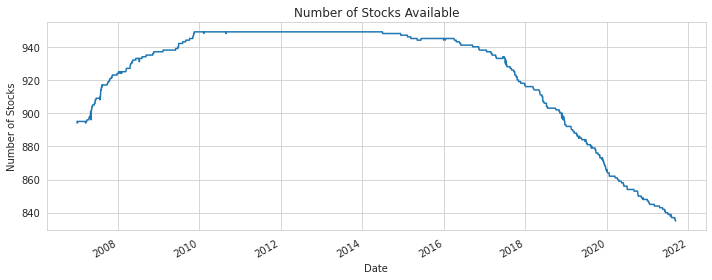

In [32]:
plot_num_stocks(prices=daily_prices_org);

In [33]:
def plot_all_stock_traces(returns, logy=True, figsize=figsize_mid):
    """
    Plot the cumulative return for all stocks.

    :param returns:
        Pandas DataFrame with stock-returns. The columns are
        for the individual stocks and the rows are for time-steps.
        
    :param logy:
        Boolean whether to use a log-scale on the y-axis.

    :param figsize:
        2-dim tuple with figure size.

    :return:
        Matplotlib Axis object.
    """
    # Calculate the cumulative stock-returns.
    # These are normalized to begin at 1.
    returns_cumprod = returns.cumprod(axis=0)
    
    # Calculate the mean of the cumulative stock-returns.
    returns_cumprod_mean = returns_cumprod.mean(axis=1, skipna=True)
    
    # Create new figure.
    fig, ax = plt.subplots(figsize=figsize)

    # Create title.
    title = 'Normalized Cumulative Stock Returns'
    
    # Plot the cumulative returns for all stocks.
    # The lines are rasterized (turned into pixels) to save space
    # when saving to vectorized graphics-file.
    returns_cumprod.plot(color='blue', alpha=0.1, rasterized=True,
                         title=title, legend=False, logy=logy, ax=ax);

    # Plot dashed black line to indicate regions of loss vs. gain.
    ax.axhline(y=1.0, color='black', linestyle='dashed')

    # Plot the mean of the cumulative stock-returns as red line.
    returns_cumprod_mean.plot(color='red', ax=ax);

    # Set label for the y-axis.
    ax.set_ylabel('Cumulative Stock Return')

    # Save plot to a file.
    filename = os.path.join(path_plots, title + '.svg')
    fig.savefig(filename, bbox_inches='tight')

    return fig

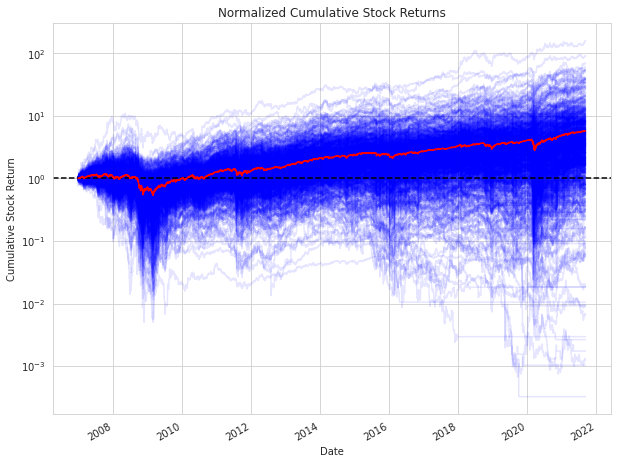

In [34]:
plot_all_stock_traces(returns=daily_returns_org, logy=True);

In [35]:
# Default pairs of portfolio types when plotting portfolio values.
default_pairs = [(REBAL, BHOLD), (REBAL_PLUS, REBAL),
                 (THRES, REBAL), (ADAPT, THRES),
                 (ADAPT_PLUS, ADAPT)]

# Pairs of portfolio types when plotting portfolio values.
# These are for the Adaptive+ robustness tests.
adp_pairs = [(ADAPT_PLUS, ADAPT),
             (ADP_HEAVY_NOISE, ADAPT),
             (ADP_PURE_NOISE, ADAPT),
             (ADP_CORR_NAIVE, ADAPT),
             (ADP_CORR_ALL, ADAPT),
             (ADP_CORR_EQUAL, ADAPT),
             (ADP_CORR_INVERT, ADAPT)]

def plot_compare_traces(df_port_val, num_stocks, test_name,
                        compare_pairs=default_pairs,
                        figsize=figsize_big):
    """
    Create a plot with several rows of sub-plots which compare
    the portfolio values for different portfolio types.

    :param df_port_val:
        DataFrame with the portfolio values obtained from
        the function `sim_many_trials`.

    :param num_stocks:
        Integer with the number of stocks in the portfolios.

    :param test_name:
        String with the test name.
        
    :param compare_pairs:
        List with tuple-pairs for portfolio types to compare.

    :param figsize:
        2-dim tuple with figure size.

    :return:
        Matplotlib Axis object.
    """
    # Create new plot with sub-plots.
    fig, axs = plt.subplots(nrows=len(compare_pairs),
                            squeeze=True, figsize=figsize)

    # For each pair of portfolio types to compare.
    for i, (port_type1, port_type2) in enumerate(compare_pairs):
        # Get the traces of the portfolio values for all trials.
        port_val1 = df_port_val.loc[port_type1, num_stocks].T
        port_val2 = df_port_val.loc[port_type2, num_stocks].T

        # Number of trials.
        num_trials = port_val1.shape[1]

        # Plot the portfolio value ratio.
        # The lines are rasterized (turned into pixels) to save
        # space when saving to vectorized graphics-file.
        port_val_ratio = port_val1 / port_val2
        port_val_ratio.plot(legend=False, color='blue', alpha=0.1,
                            rasterized=True, ax=axs[i]);
        
        # Set title.
        title = f'{port_type1} / {port_type2} ' + \
                f'({test_name}, {num_stocks} Stocks, ' + \
                f'{num_trials} Trials)'
        axs[i].set_title(title)
        
        # Don't show the axis labels.
        axs[i].set_ylabel(None)
        axs[i].set_xlabel(None)

        # Plot dashed black line to indicate regions of loss vs. gain.
        axs[i].axhline(y=1.0, color='black', linestyle='dashed')
        
        # Hide x-axis numbers.
        if i < len(compare_pairs)-1:
            axs[i].set_xticklabels([])

    # Adjust layouts for all sub-plots.
    for ax in axs:
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        
    # Adjust padding.
    fig.tight_layout()
    
    # Save plot to a file?
    filename = f'{test_name} - Compare Portfolio Traces - {num_stocks} Stocks.svg'
    filename = os.path.join(path_plots, filename)
    fig.savefig(filename, bbox_inches='tight')

    return fig

In [36]:
# Default order of portfolio types for the box-plots.
default_order = [BHOLD, REBAL, REBAL_PLUS, THRES, ADAPT, ADAPT_PLUS]

# Order of portfolio types for the Adaptive+ box-plots.
adp_order = [REBAL, ADAPT, ADAPT_PLUS,
             ADP_HEAVY_NOISE, ADP_PURE_NOISE,
             ADP_CORR_NAIVE, ADP_CORR_ALL,
             ADP_CORR_EQUAL, ADP_CORR_INVERT]

def plot_compare_stats_one(df_stats, stat_name, test_name,
                           num_trials, order=default_order):
    """
    Create a plot with a grid of box-plots that compare
    statistics for the different portfolio types.
    
    This function only compares a single performance statistic
    so you need to call the function with choices of `stat_name`
    in order to plot comparisons of different statistics.

    :param df_stats:
        DataFrame with the portfolio statistics obtained from
        the function `sim_many_trials`.

    :param stat_name:
        String with the name of the statistic to compare e.g. ARI_MEAN.

    :param test_name:
        String with the test name.
        
    :param num_trials:
        Integer with the number of trials with random portfolios.
        
    :param order:
        List with the order of portfolio types to use in box-plot.
        
    :return:
        Matplotlib Axis object.
    """
    
    # Create a grid of sub-plots.
    g = sns.FacetGrid(data=df_stats.reset_index(),
                      col=NUM_STOCKS, col_wrap=3)
    
    # Show a box-plot in each of the sub-plots.
    g.map(sns.boxplot, PORT_TYPE, stat_name, order=order)

    # Rotate x-axis labels.
    g.set_xticklabels(rotation=90)

    # Set the plot's title.
    title = f'{stat_name} ({test_name}, {num_trials} Trials)'
    g.fig.suptitle(title)
    
    # For all sub-plots.
    for ax in g.axes:
        # Remove the x-axis label 'Portfolio Type'.
        ax.set_xlabel('')
        
        # Enable grid-lines for both x- and y-axis.
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)

        # Use percentages on the y-axis?
        if stat_name in [CASH_MEAN, MONTHS_LOSS,
                         MAX_DRAWDOWN, MAX_PULLUP]:
            ax.yaxis.set_major_formatter(pct_formatter0)
        
    # Adjust padding.
    g.tight_layout()

    # Save plot to a file.
    filename = f'{test_name} - Compare Stats - {stat_name}.svg'
    filename = os.path.join(path_plots, filename)
    g.savefig(filename, bbox_inches='tight')

    return g

In [37]:
def plot_compare_stats_all(df_stats, test_name, num_stocks,
                           num_trials, order=default_order):
    """
    Create a plot with a grid of box-plots that compare
    statistics for the different portfolio types.
    
    This function shows all performance statistics in a single
    plot, and it keeps the number of stocks fixed.

    :param df_stats:
        DataFrame with the portfolio statistics obtained from
        the function `sim_many_trials`.

    :param test_name:
        String with the test name.
        
    :param num_stocks:
        Integer with the number of stocks in the portfolios.
        
    :param num_trials:
        Integer with the number of trials with random portfolios.
        
    :param order:
        List with the order of portfolio types to use in the box-plots.
        
    :return:
        Matplotlib Axis object.
    """
    
    # Names of the statistics we want to plot.
    list_stat_names = [ARI_MEAN, STD, SHARPE_RATIO,
                       CASH_MEAN, MAX_DRAWDOWN, MAX_PULLUP]

    # Transform the Pandas DataFrame for use in the Seaborn plotting.
    id_vars = [PORT_TYPE, NUM_STOCKS, TRIAL]
    df_stats2 = df_stats[list_stat_names].reset_index()
    df_stats2 = df_stats2.melt(id_vars=id_vars)
    
    # Only use data-rows that have the given number of stocks.
    mask = (df_stats2[NUM_STOCKS] == num_stocks)
    df_stats2 = df_stats2[mask]
    
    # Ensure the DataFrame is not empty.
    assert len(df_stats2) > 0, 'DataFrame is empty'
    
    # Create a grid of sub-plots.
    g = sns.FacetGrid(data=df_stats2, col='variable',
                      col_wrap=3, sharey=False)

    # Show a box-plot in each of the sub-plots.
    g.map(sns.boxplot, PORT_TYPE, 'value', order=order)
    g.set_xticklabels(rotation=90)

    # Set the plot's main title.
    title = f'All Statistics ({test_name}, {num_stocks} Stocks, {num_trials} Trials)'
    g.fig.suptitle(title)
    g.fig.subplots_adjust(top=.9)
    
    # For each sub-plot.
    for stat_name, ax in zip(list_stat_names, g.axes):
        # Set the sub-plot title.
        ax.set_title(stat_name)

        # Set the axis-labels.
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Enable grid-lines for both x- and y-axis.
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)

        # Use percentages on the y-axis?
        if stat_name in [CASH_MEAN, MONTHS_LOSS,
                         MAX_DRAWDOWN, MAX_PULLUP]:
            ax.yaxis.set_major_formatter(pct_formatter0)

    # Save the figure to disk.
    filename = f'{test_name} - Compare Stats All.svg'
    filename = os.path.join(path_plots, filename)
    g.savefig(filename, bbox_inches='tight')

    return g

## Statistical Functions

In [38]:
def geo_mean(port_val):
    """
    Calculate the geometric mean for a portfolio's value
    from the start-point to the end-point.
    
    :param port_val:
        Pandas Series with the portfolio values at each time-step.
        
    :return:
        Float with the geometric mean.
    """
    return (port_val.iloc[-1] / port_val.iloc[0]) ** (1.0 / len(port_val))

In [39]:
def statistics(port_val, cash, pullup_window=None):
    """
    Calculate various statistics for a time-series containing
    the values of a stock-portfolio through time.
    
    Note: The Sharpe Ratio is calculated from the 1-period
    returns using their arithemetic mean and std.dev. without
    a risk-free or benchmark return.
    
    :param num_stocks:
        Integer with the number of stocks in the portfolios.

    :param port_val:
        Pandas Series with the portfolio values at each time-step.
        
    :param pullup_window:
        Integer with window-length for the Max Pullup statistic.

    :return:
        Dict with various statistics.
    """
    # Calculate 1-period returns for the portfolio.
    rets_daily = port_val.pct_change(1) + 1.0
    
    # Calculate the fraction of months that have losses.
    # We count all 21-day periods, because there are about
    # 21 trading days on average per month.
    # Note that we don't +1 the returns because we would
    # just have to subtract them again.
    rets_monthly = port_val.pct_change(21).dropna()
    months_loss = (rets_monthly < 0.0).sum() / len(rets_monthly)

    # Arithmetic mean and std.dev. for the 1-period returns.
    ari_mean = rets_daily.mean()
    std = rets_daily.std()
    
    # Sharpe Ratio for the 1-period returns.
    if std>0.0:
        # The std.dev. is positive.
        sharpe_ratio = (ari_mean - 1.0) / std
    else:
        # The std.dev. is zero so we cannot divide with it.
        # Maybe we should set this to zero instead?
        sharpe_ratio = np.nan
    
    # Create dict with the statistics.
    data = \
    {
        NUM_DATA_POINTS: len(port_val),
        PORT_END_VAL: port_val.iloc[-1],
        CASH_MEAN: np.mean(cash),
        ARI_MEAN: ari_mean,
        GEO_MEAN: geo_mean(port_val=port_val),
        STD: std,
        SHARPE_RATIO: sharpe_ratio,
        MAX_DRAWDOWN: max_drawdown(df=port_val).min(),
        MAX_PULLUP: max_pullup(df=port_val, window=pullup_window).max(),
        MONTHS_LOSS: months_loss,
    }

    return data

## Correlation Adjustment

In [40]:
def adjust_weights_corr(returns, weights, corr_type='window',
                        corr_window=10, corr_invert=False,
                        corr_equal=0.1, corr_noise_scale=0.0):
    """
    Adjust portfolio weights to minimize correlation between assets.
    
    This function is intended for simulation and research purposes,
    as it can "cheat" and use the correlation of future returns.

    For real-world investments you should instead use the underlying
    function `diversify.adjust_weights`.
    
    :param returns:
        Pandas DataFrame with asset-returns.
        Rows are for the time-steps. Columns are for the assets.

    :param weights:
        Pandas DataFrame with asset-weights in the portfolio.
        Rows are for the time-steps. Columns are for the assets.
        
    :param corr_type:
        String with the correlation-type to use.
        'all' uses the correlations of the entire `returns` data.
        'window' only uses the correlation of a rolling window.
        'pure-noise' only uses random uniform noise.
        
    :param corr_window:
        Integer with the length of the rolling window which is
        used if `corr_type == 'window'`.
        
    :param corr_invert:
        Boolean whether to invert the correlation matrix.
        This is only used if `corr_type == 'window'`.
        This is used for robustness testing.
    
    :param corr_noise_scale:
        Float. If greater than 0.0 then random normal noise
        is added to the correlation matrix, where this arg
        is used as the std.dev. of the random numbers.
        This is only used if `corr_type == 'window'`.
        This is used for robustness testing.
    
    :return:
        Pandas DataFrame with the adjusted portfolio weights.
    """

    assert corr_type in ['all', 'window', 'pure-noise', 'equal']
    
    # Number of assets.
    num_assets = weights.shape[1]

    # Copy the original weights to a new DataFrame.
    weights_new = weights.copy()
    
    if corr_type == 'all':
        # Use correlation matrix for the entire time-series.
        corr = returns.corr().to_numpy()
    elif corr_type == 'equal':
        # All correlations are equal.
        corr = np.full(fill_value=corr_equal, shape=(num_assets, num_assets))

        # Ensure diagonal is all ones.
        np.fill_diagonal(corr, val=1.0)

    # For each time-step.
    for idx, weights_org in weights.iterrows():
        # Original portfolio weights for this time-step.
        weights_org = weights_org.to_numpy()

        # What kind of correlation matrix should be used?
        if corr_type == 'pure-noise':
            # All correlations are uniform random numbers
            # between -1 and 1.
            corr = rng.uniform(low=-1.0, high=1.0,
                               size=(num_assets, num_assets))

            # Ensure the correlation matrix is valid.
            fix_correlation_matrix(corr)

        elif corr_type == 'window':
            # Use correlation matrix for a rolling window.
            if corr_window > 0:
                # Use FUTURE data for the correlation matrix.
                idx_start = idx
                idx_end = idx + timedelta(days=corr_window)
            else:
                # Use PAST data for the correlation matrix.
                idx_start = idx + timedelta(days=corr_window)
                idx_end = idx

            # Calculate correlation for a slice of time-steps.
            returns_slice = returns[idx_start:idx_end]
            corr = returns_slice.corr()
            
            # Convert Pandas DataFrame to Numpy matrix.
            corr = corr.to_numpy()

            # Add random noise to the correlation matrix?
            if corr_noise_scale > 0.0:
                # New noise is added for every time-step, unlike
                # the noise for the future returns where the same
                # noise is added for all time-steps of each asset.
                noise_corr = rng.normal(loc=0.0, size=corr.shape,
                                        scale=corr_noise_scale)
                corr = corr + noise_corr

            # Invert the correlation matrix?
            if corr_invert:
                corr = -corr
                
            # Ensure the correlation matrix is valid.
            fix_correlation_matrix(corr)

        # Ensure the correlation matrix is valid.
        # This is not really necessary because we already ensure
        # the correlation matrix is valid in the above, but we
        # want to be completely certain everything is OK, in case
        # we experiment further and make a mistake somewhere.
        check_correlation_matrix(corr)

        # Adjust the portfolio weights for this time-step.
        weights_new.loc[idx] = \
            diversify.adjust_weights(weights_org=weights_org,
                                     corr=corr, step_size=1.0)
        
    return weights_new

In [41]:
# Create partial function instances of `adjust_weights_corr`
# which bind some of the args for different correlations.

# Use correlations for entire time-series.
func_adj_corr_all = \
    partial(adjust_weights_corr, corr_type='all')

# Use the last 10-days correlation as "naive" forecasting.
func_adj_corr_naive = \
    partial(adjust_weights_corr, corr_type='window',
            corr_window=-10)

# Use the actual future 10-day correlations with heavy noise.
func_adj_corr_heavy_noise = \
    partial(adjust_weights_corr, corr_type='window',
            corr_window=10, corr_noise_scale=0.5)

# Use pure noise for the correlations.
func_adj_corr_pure_noise = \
    partial(adjust_weights_corr, corr_type='pure-noise')

# Use correlations that are all equal.
func_adj_corr_equal = \
    partial(adjust_weights_corr, corr_type='equal', corr_equal=0.1)

# Use the inverted actual future 10-day correlations.
func_adj_corr_invert = \
    partial(adjust_weights_corr, corr_type='window',
            corr_window=10, corr_invert=True)

## Portfolio Functions

These functions calculate the cumulative returns for the different types of portfolios.

In [42]:
def portfolio_bhold(returns):
    """
    Calculate the cumulative returns for a Buy&Hold portfolio.
    
    :param returns:
        Pandas DataFrame with asset-returns.
        Rows are for the time-steps. Columns are for the assets.

    :return:
        Pandas Series with cumulative portfolio returns.
    """
    return returns.cumprod().mean(axis=1, skipna=True)

In [43]:
def portfolio_rebal(returns):
    """
    Calculate the cumulative returns for a Rebalanced portfolio.

    :param returns:
        Pandas DataFrame with asset-returns.
        Rows are for the time-steps. Columns are for the assets.

    :return:
        Pandas Series with cumulative portfolio returns.
    """
    return returns.mean(axis=1, skipna=True).cumprod()

In [44]:
def portfolio_rebal_plus(returns, max_weight, func_adjust_corr):
    """
    Calculate the cumulative returns for a Rebalanced portfolio
    where the weights are first set to be equal, but then they
    are adjusted so as to minimize the correlations.

    :param returns:
        Pandas DataFrame with asset-returns.
        Rows are for the time-steps. Columns are for the assets.

    :param max_weight:
        Float with the max asset-weight.

    :param func_adjust_corr:
        Function for adjusting the asset-weights so their
        correlation is minimized.

    :return:
        Pandas Series with cumulative portfolio returns.
    """
    # Initialize the weights to be equal.
    # Copy the Pandas DataFrame to get the same index and columns.
    weights = returns.copy()
    weights[:] = max_weight
    
    # Adjust the asset-weights to minimize their correlation.
    weights = func_adjust_corr(returns=returns, weights=weights)

    # Clip the asset-weights at their upper limit.
    weights = np.minimum(weights, max_weight)

    # Normalize the asset-weights so they sum to max 1.
    weights_norm, cash = normalize_weights(weights=weights, check_result=True)
    
    # Calculate the cumulative portfolio returns.
    port_val = weighted_returns(weights=weights_norm, cash=cash, returns=returns)
    
    return port_val, cash

In [45]:
def portfolio_thres(returns, future_returns, min_return, max_weight):
    """
    Calculate the cumulative returns for a Threshold portfolio
    that invests equal parts of the portfolio in assets whose
    future returns are above the given threshold.

    :param returns:
        Pandas DataFrame with asset-returns.
        Rows are for the time-steps. Columns are for the assets.

    :param future_returns:
        Pandas DataFrame with future asset-returns.
        Rows are for the time-steps. Columns are for the assets.
    
    :param min_return:
        Float with the threshold compared to `future_returns`
        to determine if the portfolio should invest in an asset.

    :param max_weight:
        Float with the max portfolio-weight for each asset.
        In case the portfolio only invests in a few assets,
        this is used to limit the amount invested in each asset.

    :return:
        Pandas Series with cumulative portfolio returns.
    """

    # Calculate the asset-weights.
    # Only invest in assets with sufficiently high future returns.
    weights = (future_returns > min_return) * max_weight
    
    # Normalize the asset-weights so they sum to max 1.
    weights_norm, cash = normalize_weights(weights=weights, check_result=True)

    # Calculate the cumulative portfolio returns.
    port_val = weighted_returns(weights=weights_norm, cash=cash, returns=returns)
    
    return port_val, cash

In [46]:
def portfolio_adapt(returns, future_returns,
                    min_return, max_return,
                    min_weight, max_weight,
                    func_adjust_corr=None):
    """
    Calculate the cumulative returns for an Adaptive portfolio
    which only invests in the assets that have positive future
    returns, and the asset-weights are proportional to the
    future returns, so more of the portfolio is invested in assets
    that have higher future returns.
    
    The asset-weights are calculated as a simple linear map
    where `min_return` is mapped to `min_weight` and `max_return`
    is mapped to `max_weight`.

    :param returns:
        Pandas DataFrame with asset-returns.
        Rows are for the time-steps. Columns are for the assets.

    :param future_returns:
        Pandas DataFrame with future asset-returns.
        Rows are for the time-steps. Columns are for the assets.
    
    :param min_return:
        Float with the min future return required for an asset.
        This maps to `min_weight`.

    :param max_return:
        Float with the max future return for an asset.
        This maps to `max_weight`.

    :param min_weight:
        Float with the min asset-weight.
        
    :param max_weight:
        Float with the max asset-weight.

    :param func_adjust_corr:
        Function for adjusting the asset-weights so their
        correlation is minimized.

    :return:
        Pandas Series with cumulative portfolio returns.
    """

    # Map the future returns to asset-weights.
    weights = linear_map(x=future_returns, clip='lo',
                         x_lo=min_return, x_hi=max_return,
                         y_lo=min_weight, y_hi=max_weight)
    
    # Adjust the asset-weights to minimize their correlation?
    if func_adjust_corr is not None:
        weights = func_adjust_corr(returns=returns, weights=weights)

    # Clip the asset-weights at their upper limit.
    weights = np.minimum(weights, max_weight)

    # Normalize the asset-weights so they sum to max 1.
    weights_norm, cash = normalize_weights(weights=weights, check_result=True)

    # Calculate the cumulative portfolio returns.
    port_val = weighted_returns(weights=weights_norm, cash=cash, returns=returns)
    
    return port_val, cash

## Simulation Functions

In [47]:
def sim_one_trial(trial, num_stocks, returns, future_returns, 
                  min_return=0.1, max_return=0.5,
                  min_weight=0.0, max_weight=0.1,
                  noise_scale_future_rets=0.0,
                  func_adjust_corr=adjust_weights_corr,
                  use_bhold=True, use_thres=True,
                  use_rebal=True, use_rebal_plus=True,
                  use_adapt=True, use_adapt_plus=True,
                  use_adp_corr_all=False, use_adp_corr_naive=False,
                  use_adp_heavy_noise=False, use_adp_pure_noise=False,
                  use_adp_corr_equal=False, use_adp_corr_invert=False,
                  pullup_window=250):
    """
    Perform one simulation of the different portfolio types
    for a random selection of stock-tickers.
    
    This is not intended to be used directly, but should be
    used through the function `sim_many_trials` instead.
    
    :param trial:
        Integer with the trial number.
    
    :param num_stocks:
        Integer with the number of stocks in the portfolios.

    :param returns:
        Pandas DataFrame with asset-returns.
        Rows are for the time-steps. Columns are for the assets.

    :param future_returns:
        Pandas DataFrame with future asset-returns.
        Rows are for the time-steps. Columns are for the assets.

    :param min_return:
        See functions `portfolio_thres` and `portfolio_adapt`.
    :param max_return:
        See functions `portfolio_thres` and `portfolio_adapt`.
    :param min_weight:
        See functions `portfolio_thres` and `portfolio_adapt`.
    :param max_weight:
        See functions `portfolio_thres` and `portfolio_adapt`.

    :param noise_scale_future_rets:
        Float. If greater than 0.0 then add random normal noise
        to the future stock-returns which are used in the
        Threshold and Adaptive portfolios to determine the
        asset-weights in the portfolio. This is used to test
        robustness when the estimates for future stock-returns
        are noisy. This scale is the std.dev. for the noise.
        
    :param func_adjust_corr:
        Function used to adjust the asset-weights to minimize
        correlation between the assets. By default this function
        is either `adjust_weights_corr` but it can also be a
        derivation of it e.g. to add noise to the correlation
        matrices, which is used to test robustness.
        
    :param use_bhold: Bool whether to simulate Buy&Hold portfolios.
    :param use_rebal: Bool whether to simulate Rebalanced portfolios.
    :param use_rebal_plus:
        Bool whether to simulate Rebalanced+ portfolios which
        adjust the portfolio weights for correlation.
    :param use_thres: Bool whether to simulate Threshold portfolios.
    :param use_adapt: Bool whether to simulate Adaptive portfolios.
    :param use_adapt_plus:
        Bool whether to simulate Adaptive+ portfolios. Note that
        these are somewhat slow to calculate because they adjust
        the portfolio weights for each time-step to minimize
        correlation.
    :param use_adp_corr_all:
        Bool whether to simulate Adaptive+ portfolios using the
        correlations for all the daily returns in the data-set.
    :param use_adp_corr_naive:
        Bool whether to simulate Adaptive+ portfolios using the
        correlations from the previous 10 days as a naive forecast.
    :param use_adp_heavy_noise:
        Bool whether to simulate Adaptive+ portfolios using the
        correlations for the future 10 days with heavy noise.
    :param use_adp_pure_noise:
        Bool whether to simulate Adaptive+ portfolios using
        pure noise for the correlations.
    :param use_adp_corr_equal:
        Bool whether to simulate Adaptive+ portfolios using
        correlations that are all equal.
    :param use_adp_corr_invert:
        Bool whether to simulate Adaptive+ portfolios using the
        correlations for the future 10 days that are inverted.

    :param pullup_window:
        Integer for the window in calculating the Max Pullup statistic.
        
    :return:
        list_stats: List of Pandas DataFrames with statistics.
        list_port_val: List of Pandas Series with portfolio values.
        list_index: List of tuples with index-values.
    """
    # Print status message.
    msg = f'\rnum_stocks: {num_stocks}, trial: {trial}       '
    print(msg, end='\r')

    # List for logging the statistics of the trials.
    list_stats = []

    # List for logging the portfolio values of the trials.
    list_port_val = []

    # List for logging the index values of the trials.
    list_index = []
    
    # Helper-function for logging the results of the trial.
    def log(port_val, cash, port_type):
        # Calculate performance statistics.
        stats = statistics(port_val=port_val, cash=cash,
                           pullup_window=pullup_window)
        
        # Append all the relevant data to the log-lists.
        list_stats.append(stats)
        list_port_val.append(port_val)
        list_index.append((port_type, num_stocks, trial))
        
    # All available stock-tickers.
    all_tickers = returns.columns

    # Because this function is run in parallel, we must initialize
    # a new Random Number Generator for each thread, otherwise the
    # random tickers would be identical for all parallel threads.
    rng = np.random.default_rng()
    
    # Select random tickers.
    tickers = rng.choice(all_tickers, size=num_stocks, replace=False)

    # Get the stock-returns for those tickers, and only use
    # their common periods by dropping rows that have NaN
    # (Not-a-Number) elements. This should only drop rows
    # at the beginning and end of the time-series, unless
    # there are missing data-points for some stocks.
    rets = returns[tickers].dropna(how='any')

    # Get the future long-term stock-returns for the tickers,
    # and only use their common periods by dropping rows
    # that have NaN elements.
    future_rets = future_returns[tickers].dropna(how='any')

    # Only use rows where we have data for both the daily
    # stock-returns and the future long-term stock-returns.
    common_index = rets.index.intersection(future_rets.index)
    rets = rets.loc[common_index]
    future_rets = future_rets.loc[common_index]

    # Add noise to the future long-term stock-returns?
    if noise_scale_future_rets > 0.0:
        # Generate one noise-sample per stock.
        noise = rng.normal(loc=0.0, size=num_stocks,
                           scale=noise_scale_future_rets)
        # Add the same noise-sample to all time-stamps.
        # We could clip it on the low side so the future
        # return cannot be less than zero, but it is not
        # necessary for the Threshold and Adaptive
        # portfolio methods that use the future_rets.
        future_rets = future_rets + noise

    # Buy & Hold portfolio simulation.
    if use_bhold:
        port_val = portfolio_bhold(returns=rets)
        log(port_val=port_val, cash=0.0, port_type=BHOLD, )

    # Rebalanced portfolio simulation.
    if use_rebal:
        port_val = portfolio_rebal(returns=rets)
        log(port_val=port_val, cash=0.0, port_type=REBAL)

    # Rebalanced+ portfolio simulation.
    if use_rebal_plus:
        port_val, cash = \
            portfolio_rebal_plus(returns=rets,
                        max_weight=max_weight,
                        func_adjust_corr=func_adjust_corr)
        log(port_val=port_val, cash=cash, port_type=REBAL_PLUS)

    # Threshold portfolio simulation.
    if use_thres:
        port_val, cash = \
            portfolio_thres(returns=rets,
                            future_returns=future_rets,
                            min_return=min_return,
                            max_weight=max_weight)
        log(port_val=port_val, cash=cash, port_type=THRES)

    # Adaptive portfolio simulation.
    if use_adapt:
        port_val, cash = \
            portfolio_adapt(returns=rets,
                            future_returns=future_rets,
                            min_return=min_return,
                            max_return=max_return,
                            min_weight=min_weight,
                            max_weight=max_weight)
        log(port_val=port_val, cash=cash, port_type=ADAPT)

    # Adaptive+ portfolio simulation.
    if use_adapt_plus:
        port_val, cash = \
            portfolio_adapt(returns=rets,
                            future_returns=future_rets,
                            min_return=min_return,
                            max_return=max_return,
                            min_weight=min_weight,
                            max_weight=max_weight,
                            func_adjust_corr=func_adjust_corr)
        log(port_val=port_val, cash=cash, port_type=ADAPT_PLUS)

    # Adaptive+ with correlation for entire data-period.
    if use_adp_corr_all:
        port_val, cash = \
            portfolio_adapt(returns=rets,
                            future_returns=future_rets,
                            min_return=min_return,
                            max_return=max_return,
                            min_weight=min_weight,
                            max_weight=max_weight,
                            func_adjust_corr=func_adj_corr_all)
        log(port_val=port_val, cash=cash, port_type=ADP_CORR_ALL)

    # Adaptive+ with naive forecasting of the correlation.
    if use_adp_corr_naive:
        port_val, cash = \
            portfolio_adapt(returns=rets,
                            future_returns=future_rets,
                            min_return=min_return,
                            max_return=max_return,
                            min_weight=min_weight,
                            max_weight=max_weight,
                            func_adjust_corr=func_adj_corr_naive)
        log(port_val=port_val, cash=cash, port_type=ADP_CORR_NAIVE)

    # Adaptive+ with Heavy Noise for the correlation.
    if use_adp_heavy_noise:
        port_val, cash = \
            portfolio_adapt(returns=rets,
                            future_returns=future_rets,
                            min_return=min_return,
                            max_return=max_return,
                            min_weight=min_weight,
                            max_weight=max_weight,
                            func_adjust_corr=func_adj_corr_heavy_noise)
        log(port_val=port_val, cash=cash, port_type=ADP_HEAVY_NOISE)

    # Adaptive+ with Pure Noise for the correlation.
    if use_adp_pure_noise:
        port_val, cash = \
            portfolio_adapt(returns=rets,
                            future_returns=future_rets,
                            min_return=min_return,
                            max_return=max_return,
                            min_weight=min_weight,
                            max_weight=max_weight,
                            func_adjust_corr=func_adj_corr_pure_noise)
        log(port_val=port_val, cash=cash, port_type=ADP_PURE_NOISE)

    # Adaptive+ with all correlations being one.
    if use_adp_corr_equal:
        port_val, cash = \
            portfolio_adapt(returns=rets,
                            future_returns=future_rets,
                            min_return=min_return,
                            max_return=max_return,
                            min_weight=min_weight,
                            max_weight=max_weight,
                            func_adjust_corr=func_adj_corr_equal)
        log(port_val=port_val, cash=cash, port_type=ADP_CORR_EQUAL)
        
    # Adaptive+ with all correlations being inverted.
    if use_adp_corr_invert:
        port_val, cash = \
            portfolio_adapt(returns=rets,
                            future_returns=future_rets,
                            min_return=min_return,
                            max_return=max_return,
                            min_weight=min_weight,
                            max_weight=max_weight,
                            func_adjust_corr=func_adj_corr_invert)
        log(port_val=port_val, cash=cash, port_type=ADP_CORR_INVERT)
    
    return list_stats, list_port_val, list_index

In [48]:
def sim_many_trials(num_stocks, num_trials, **kwargs):
    """
    Perform many simulations of the different portfolio types
    for random selections of stock-tickers in each trial.
    
    This is a wrapper for the function `sim_one_trial` which
    handles the parallel execution and converts the lists of
    results to Pandas DataFrames.
    
    :param num_stocks:
        Either an integer or list of integers with the number
        of random stocks in the portfolios.

    :param num_trials:
        Integer with the number of trials with random portfolios.

    :param kwargs:
        Other keyword-arguments passed to `sim_one_trial`.

    :return:
        df_stats: Pandas DataFrame with statistics for all trials.
        df_port_val: Pandas DataFrame with all the portfolio traces.
    """

    # Ensure num_stocks is a list.
    if isinstance(num_stocks, int):
        list_num_stocks = [num_stocks]
    elif isinstance(num_stocks, list):
        list_num_stocks = num_stocks
    else:
        msg = 'num_stocks should be either int or list'
        raise TypeError(msg)
    
    # Initialize lists for the results.
    list_stats = []
    list_port_val = []
    list_index = []

    # For each choice of num_stocks.
    for num_stocks in list_num_stocks:
        # Ensure the number of portfolio stocks is valid.
        assert num_stocks < len(all_tickers)
        
        # The parallel execution system cannot handle extra args,
        # so we create a new partial function with those args set.
        func = partial(sim_one_trial, num_stocks=num_stocks, **kwargs)

        # Parallel run of the function `sim_one_trial`.
        with mp.Pool(processes=None) as pool:
            results = pool.map(func, range(num_trials))
        
        # Unpack and log the results for later use.
        # The data-structure of the results is quite complicated:
        # It is a list of tuples of lists of data.
        stats, port_val, index = zip(*results)
        list_stats += list(chain(*stats))
        list_port_val += list(chain(*port_val))
        list_index += list(chain(*index))

    # Create index for the Pandas DataFrames from the logs.
    names = [PORT_TYPE, NUM_STOCKS, TRIAL]
    index = pd.MultiIndex.from_tuples(list_index, names=names)

    # Create Pandas DataFrames from the logs of the results.
    df_stats = pd.DataFrame(list_stats, index=index)
    df_port_val = pd.DataFrame(list_port_val, index=index)
    
    # Sort index so the DataFrames are faster to work with.
    df_stats = df_stats.sort_index()
    df_port_val = df_port_val.sort_index()
    
    return df_stats, df_port_val

## Other Helper Functions

In [49]:
def sim_plot_all(test_name, num_stocks, num_trials,
                 compare_pairs=default_pairs,
                 order=default_order, **kwargs):
    """
    First perform simulations of random portfolios, and then
    plot all the resulting statistics, etc.
    
    :param test_name:
        String with the test-name used in titles and filenames.

    :param num_stocks:
        List of integers with the number of stocks.
    
    :param num_trials:
        Integer with the number of trials with random portfolios.

    :param compare_pairs:
        List with tuple-pairs for portfolio types to compare
        in the plots of the function `plot_compare_traces`.
    
    :param order:
        List with the order of portfolio types to use in the
        box-plots in the function `plot_compare_stats_all`.

    :param kwargs:
        Other keyword-arguments passed to `sim_many_trials`.
    """
    
    # Portfolio simulations.
    df_stats, df_port_val = \
        sim_many_trials(num_stocks=num_stocks,
                        num_trials=num_trials, **kwargs)

    # Plot all comparisons of the portfolio traces.
    for _num_stocks in num_stocks:
        plot_compare_traces(df_port_val=df_port_val,
                            num_stocks=_num_stocks,
                            test_name=test_name,
                            compare_pairs=compare_pairs)
    
    # Compare the portfolio simulations on these statistics.
    list_stat_names = [ARI_MEAN, GEO_MEAN, STD, SHARPE_RATIO,
                       CASH_MEAN, MAX_DRAWDOWN, MAX_PULLUP,
                       MONTHS_LOSS]

    # Plot all comparisons of the performance statistics.
    for stat_name in list_stat_names:
        plot_compare_stats_one(df_stats=df_stats, stat_name=stat_name,
                               test_name=test_name, num_trials=num_trials,
                               order=order)

## Variance is NOT Risk! - A B Comparison

In [50]:
def gen_normal_pdf(x, mean, std, name):
    """
    Generate the Probability Density Function (PDF) for a
    normal distribution with the given parameters, as well
    as a label for use in plotting.
    
    :param x: Array of floats for which the PDF should be calculated.
    :param mean: Float with mean of the normal distribution.
    :param std: Float with std.dev. of the normal distribution.
    :param name: String to be prepended the label.
    :return:
        Numpy array with floats for the PDF-values.
        String with a label for use in plotting.
    """
    # Calculate the PDF.
    pdf = norm.pdf(x, loc=mean, scale=std)

    # Probability of loss.
    prob_loss = normal_prob_loss(mean=mean, std=std)

    # Label for use in plotting.
    label = f'{name}: $\mu$ = {mean:.0%} / $\sigma$ = {std:.0%} / Prob. Loss = {prob_loss:.2f}'

    return pdf, label

In [51]:
def plot_compare_normals(mean1, mean2, std1, std2, names,
                         xlabel='Asset Return', x_min=-0.4, x_max=0.4,
                         filename=None, figsize=figsize_big):
    """
    Plot multiple comparisons of two normal distributions X1 and X2,
    where X1 ~ N(mean1[i], std1[i]^2) and X2 ~ N(mean2[i], std2[i]^2).
    Also show the probability of loss for each, and the probablity
    that X1 < X2.
    
    :param mean1: List of floats for the mean of X1.
    :param std1: List of floats for the std.dev. of X1.
    :param mean2: List of floats for the mean of X2.
    :param std2: List of floats for the std.dev. of X2.
    :param names: List of strings with the names for X1 and X2.
    :param x_min: Float with min value for x-axis.
    :param x_max: Float with max value for x-axis.
    :param xlabel: String with label for the x-axis.
    :param figsize: Tuple with the figure-size.
    :return: Matplotlib Axis object.
    """
    # Number of sub-plots.
    num_plots = len(mean1)
    
    # Create a plot with multiple rows of sub-plots.
    fig, axs = plt.subplots(nrows=num_plots, figsize=figsize)

    # Evenly spaced values for the x-axis.
    x = np.linspace(x_min, x_max, 200)
    
    # Convenience variables.
    _name1 = names[0]
    _name2 = names[1]
    
    # For each sub-plot.
    for ax, _mean1, _mean2, _std1, _std2 in \
        zip(axs, mean1, mean2, std1, std2):
        # Calculate the PDF for the first random variable X1.
        pdf1, label1 = gen_normal_pdf(x=x, mean=_mean1, std=_std1, name=_name1)
        
        # Calculate the PDF for the second random variable X2.
        pdf2, label2 = gen_normal_pdf(x=x, mean=_mean2, std=_std2, name=_name2)

        # Pandas DataFrame with the PDF-values.
        data = {label1: pdf1, label2:pdf2}
        df = pd.DataFrame(data=data, index=x)

        # Plot the PDF-values.
        df.plot(ax=ax)
    
        # Probability that X1 < X2.
        prob_less_than = \
            normal_prob_less_than(mean1=_mean1, std1=_std1,
                                  mean2=_mean2, std2=_std2)

        # Title of this sub-plot.
        title = f'Prob. {_name1} Return < {_name2} Return = {prob_less_than:.2f}'
        ax.set_title(title)
        
        # Vertial line for x=0 splitting gain and loss.
        ax.axvline(x=0.0, ymin=0, ymax=1, color="black")

        # Hide numbers on y-axis.
        ax.yaxis.set_ticklabels([])

        # Show percentage-numbers on x-axis.
        ax.xaxis.set_major_formatter(pct_formatter0)

        # Set label of x-axis.
        ax.set_xlabel(xlabel)

    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk.
    if filename is not None:
        filename = os.path.join(path_plots, filename)
        fig.savefig(filename, bbox_inches='tight')

    return fig

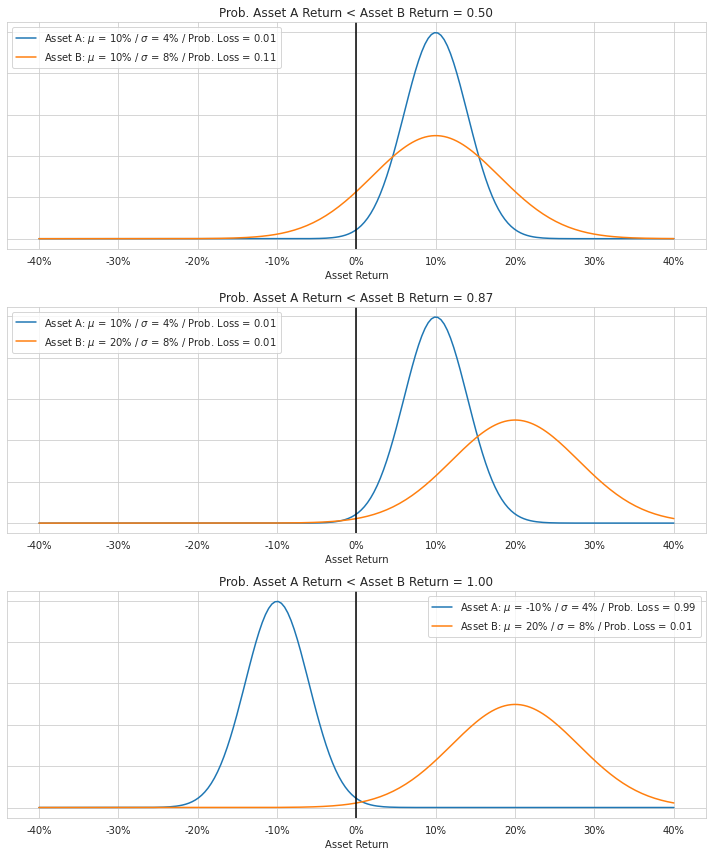

In [52]:
filename = 'Variance is NOT Risk - A B Comparison.svg'
plot_compare_normals(mean1=[0.1, 0.1, -0.1], mean2=[0.1, 0.2, 0.2],
                     std1=[0.04, 0.04, 0.04], std2=[0.08, 0.08, 0.08],
                     names=['Asset A', 'Asset B'], filename=filename);

## Variance is NOT Risk! - Probability of Loss

In [53]:
def _plot_normal_pdf(mean, std, ax, xlabel='Asset Return',
                     title=None, x_min=-0.4, x_max=0.4,
                     dashed_line_mean=True):
    """
    Plot the normal-distribution with the given mean and
    standard deviation. Show the losses in red and show
    the gains in green. Also print the probability of loss.
    
    :param mean: Float with mean of the normal distribution.
    :param std: Float with std.dev. of the normal distribution.
    :param ax: Matplotlib Axis object.
    :param xlabel: String with the x-axis label.
    :param title: String to prepend the plot title.
    :param x_min: Float with lower bound for x-axis.
    :param x_max: Float with upper bound for x-axis.
    :param dashed_line_mean: Bool whether to plot dashed line for mean.
    :return: Matplotlib Axis object.
    """
    # Arrays with negative and positive x-values.
    x1 = np.linspace(x_min, 0.0, 100)
    x2 = np.linspace(0.0, x_max, 100)

    # Arrays with y-values for the normal distribution.
    y1 = norm.pdf(x1, loc=mean, scale=std)
    y2 = norm.pdf(x2, loc=mean, scale=std)
    
    # The plots are rasterized (turned into pixels) to save space
    # when saving to vectorized graphics-file.
    
    # Fill loss-area with red.
    ax.fill_between(x1, 0.0, y1, color="red", edgecolor="red", rasterized=True)

    # Fill gain-area with green.
    ax.fill_between(x2, 0.0, y2, color="green", edgecolor="green", rasterized=True)

    # Vertical dashed line for the mean.
    if dashed_line_mean:
        ax.axvline(x=mean, ymin=0, ymax=1,
                   color="black", ls="dashed", rasterized=True)

    # Vertial line for x=0 splitting gain and loss.
    ax.axvline(x=0.0, ymin=0, ymax=1, color="black", rasterized=True)
    
    # Set x-label.
    ax.set_xlabel(xlabel)

    # Show percentage-numbers on x-axis.
    ax.xaxis.set_major_formatter(pct_formatter0)

    # Hide numbers on y-axis.
    ax.yaxis.set_ticklabels([])
    
    # Probability of loss.
    prob_loss = normal_prob_loss(mean=mean, std=std)

    # Set title.
    if title is None:
        title = ''
    title += f'$\mu$ = {mean:.1%} / $\sigma$ = {std:.1%} / Prob. Loss = {prob_loss:.2f}'
    ax.set_title(title)
    
    return ax

In [54]:
def plot_normal_pdf(mean, std, x_min=-0.4, x_max=0.4,
                    filename=None, figsize=figsize_big):
    """
    Plot one or more normal-distributions with the given means
    and standard deviations. Show the losses in red and show
    the gains in green. Also print the probability of loss.
    
    :param mean: Either a float or list of floats with means.
    :param std: Eithe rafloat or list of floats with std.dev.
    :param x_min: Float with lower bound for x-axis.
    :param x_max: Float with upper bound for x-axis.
    :param filename: String with filename to save the plot.
    :param figsize: Tuple with figure size.
    :return: Matplotlib Axis object.
    """
    
    # Make one or more sub-plots?
    if not isinstance(mean, list):
        # Create a single plot.
        fig, ax = plt.subplots(figsize=figsize)

        # Draw the plot.
        _plot_normal_pdf(mean=mean, std=std, x_min=x_min, x_max=x_max, ax=ax)
    else:
        # Number of sub-plots.
        num_plots = len(mean)

        # Create a plot with multiple sub-plots as rows.
        fig, axs = plt.subplots(nrows=num_plots, figsize=figsize)

        # Draw the sub-plots.
        for ax, _mean, _std in zip(axs, mean, std):
            _plot_normal_pdf(mean=_mean, std=_std, x_min=x_min, x_max=x_max, ax=ax)
    
    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk?
    if filename is not None:
        filename = os.path.join(path_plots, filename)
        fig.savefig(filename, bbox_inches='tight')

    return fig

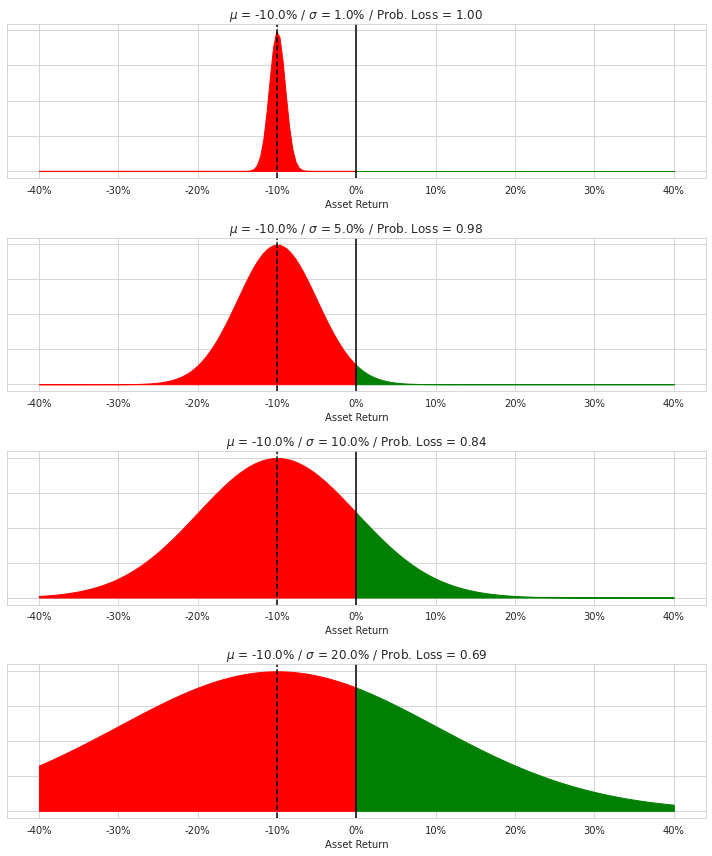

In [55]:
filename = 'Variance is NOT Risk - Probability of Loss (1).svg'
std = [0.01, 0.05, 0.1, 0.2]
plot_normal_pdf(mean=[-0.1] * 4, std=std, filename=filename);

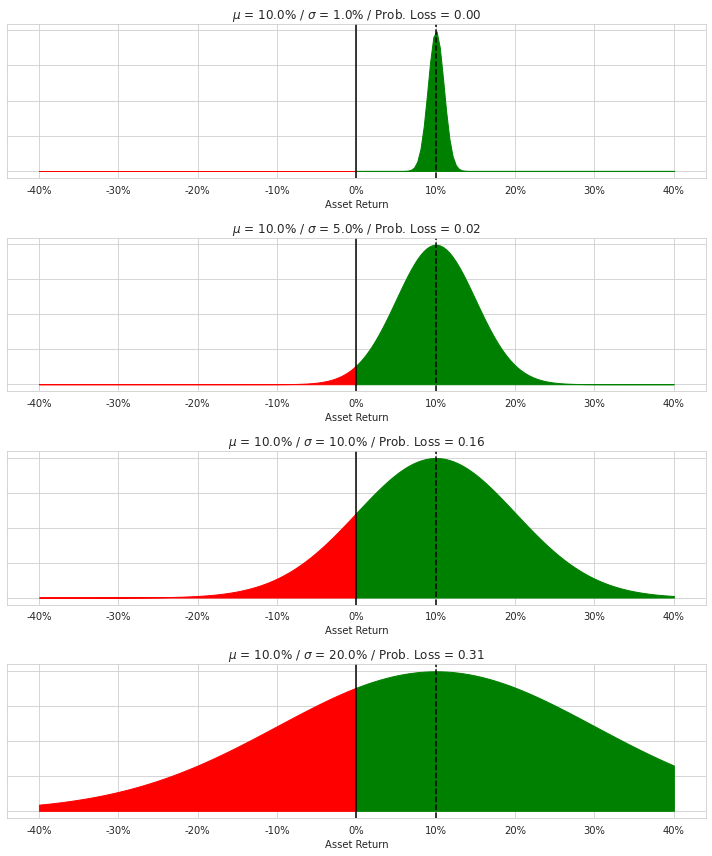

In [56]:
filename = 'Variance is NOT Risk - Probability of Loss (2).svg'
plot_normal_pdf(mean=[0.1] * 4, std=std, filename=filename);

In [57]:
def plot_compare_prob_loss(mean1, mean2, std,
                           filename=None, figsize=figsize_mid):
    """
    Plot comparison of the probability of loss for two
    normal-distributed random variables X1 and X2,
    where X1 ~ N(mean1, std[i]^2) and X2 ~ N(mean2, std[i]^2).

    :param mean1: Float with mean for X1.
    :param mean2: Float with mean for X2.
    :param std: Array with floats for the the std.dev. of X1 and X2.
    :param filename: String with filename for saving the plot.
    :param figsize: Tuple with the figure-size.
    :return: Matplotlib Axis object.
    """
    # Create a single plot.
    fig, ax = plt.subplots(figsize=figsize)

    # Plot prob.loss for mean1 and std.
    prob_loss1 = normal_prob_loss(mean=mean1, std=std)
    ax.plot(std, prob_loss1, label=f'$\mu$ = {mean1:.0%}')
    
    # Plot prob.loss for mean2 and std.
    prob_loss2 = normal_prob_loss(mean=mean2, std=std)
    ax.plot(std, prob_loss2, label=f'$\mu$ = {mean2:.0%}')

    # Show legend.
    ax.legend()
    
    # Set title.
    title = 'Compare Probability of Loss for Normal Distributions'
    ax.set_title(title)
    
    # Set axis labels.
    ax.set_xlabel('$\sigma$')
    ax.set_ylabel('Probability of Loss')

    # Show percentages on x-axis.
    ax.xaxis.set_major_formatter(pct_formatter0)
    
    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk?
    if filename is not None:
        filename = os.path.join(path_plots, filename)
        fig.savefig(filename, bbox_inches='tight')

    return fig

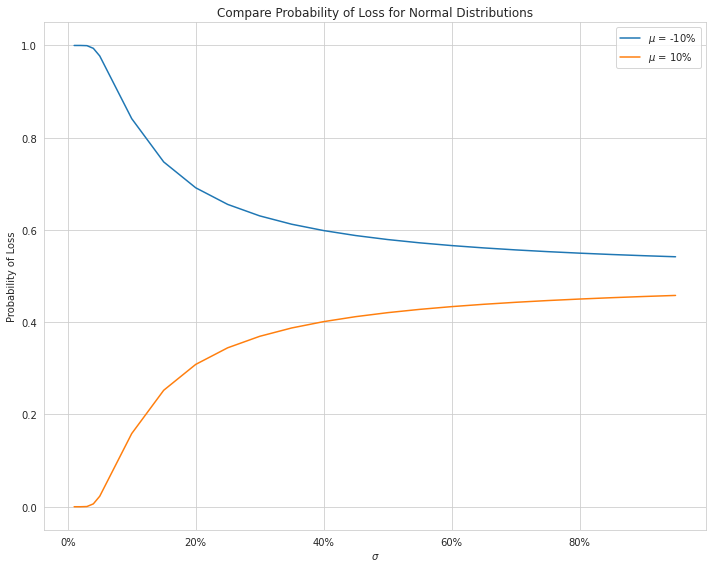

In [58]:
# Filename for the plot.
filename = 'Variance is NOT Risk - Compare Prob Loss.svg'

# Create array of std.dev. values with finer steps near zero.
std = np.concatenate([np.arange(0.01, 0.05, step=0.01),
                      np.arange(0.05, 1.0, step=0.05)])
# Ensure the std.dev. values are unique and sorted.
std = np.unique(std)

# Plot and save it.
plot_compare_prob_loss(mean1=-0.1, mean2=0.1, std=std, filename=filename);

## Variance is NOT Risk! - Minimum "Risk" Portfolio

In [59]:
def std_weighted_sum(weights, std, corr):
    """
    Calculate the standard deviation of a weighted sum of
    random variables that are correlated.
    
    :param weights: Array of weights for the random variables.
    :param std: Array of std.dev. for the random variables.
    :param corr: Matrix of correlations for the random variables.
    :return: Float with standard deviation of the weighted sum.
    """
    # Number of weights.
    num_weights = len(weights)
    
    # Init the sum.
    s = 0.0
    
    # For each pair of weights.
    # This is a nested for-loop. It can probably be made much faster.
    for i in range(num_weights):
        for j in range(num_weights):
            s += weights[i] * weights[j] * std[i] * std[j] * corr[i, j]
            
    # Take the square-root to get the std.dev.
    return np.sqrt(s)

In [60]:
def mean_std_two_assets(mean, std, corr, step=0.01):
    """
    Calculate the mean and std.dev. for a weighted sum
    of TWO random variables. The weights change between
    0.0 and 1.0 with the given step-size.
    
    :param mean: Array of means for the two assets.
    :param std: Array of std.dev. for the two assets.
    :param corr: Matrix with correlation of the two assets.
    :param step: Float with the step-size.
    :return:
        Numpy array with the means.
        Numpy array with the std.dev.
        Numpy array with the weights.
    """
    assert len(mean) == 2
    assert len(std) == 2
    assert corr.shape == (2, 2)
    
    # Init lists for holding results.
    list_mean = []
    list_std = []
    list_weights = []

    # For each weight between 0.0 and 1.0
    for weight1 in np.arange(start=0.0, stop=1.0, step=step):
        # Other weight.
        weight2 = 1.0 - weight1

        # Combine weights.
        weights = np.array([weight1, weight2])
        
        # Mean of the weighted sum.
        mean_ws = np.sum(weights * mean)
        
        # Std.dev. of the weighted sum.
        std_ws = std_weighted_sum(weights=weights, std=std, corr=corr)

        # Save results for later.
        list_mean.append(mean_ws)
        list_std.append(std_ws)
        list_weights.append(weights)
    
    return np.array(list_mean), np.array(list_std), np.array(list_weights)

In [61]:
def plot_two_assets(mean, std, corr, names,
                    filename=None, figsize=figsize_big):
    """
    Make four sub-plots for the combination of two assets:
    
    1) Plot the mean and std.dev. for all weighted combinations.
    2) Plot the normal distribution for the "minimum risk" portfolio.
    3) Plot the normal distribution for Asset A.
    4) Plot the normal distribution for Asset B.
    
    :param mean: Array of means for the two assets.
    :param std: Array of std.dev. for the two assets.
    :param corr: Matrix with correlation of the two assets.
    :param names: List of strings for the two asset names.
    :param filename: String with filename for saving the plot.
    :param figsize: Tuple with figure-size.
    :return: Matplotlib Axis object.
    """
    # Calculate mean and std.dev. for all weighted combinations
    # of the two assets.
    list_mean, list_std, list_weights = \
        mean_std_two_assets(mean=mean, std=std, corr=corr)
    
    # Find the "minimum risk" combination which minimizes std.dev.
    idx = np.argmin(list_std)
    min_risk_mean = list_mean[idx]
    min_risk_std = list_std[idx]
    
    # Print the "minimum risk" weights.
    print('Minimum Risk weights: ', list_weights[idx])

    # Probability of loss for the "min risk" portfolio.
    prob_loss = normal_prob_loss(mean=min_risk_mean, std=min_risk_std)

    # Create new plot.
    fig, axs = plt.subplots(nrows=4, figsize=figsize)

    # Plot the mean and std.dev. for the weighted asset sum.
    # This is the Pareto or Efficient front for only two assets.
    # Pos. means are shown in green, neg. means are shown in red.
    mask_loss = (list_mean < 0.0)
    mask_gain = ~mask_loss
    axs[0].plot(list_mean[mask_loss], list_std[mask_loss], color='red')
    axs[0].plot(list_mean[mask_gain], list_std[mask_gain], color='green')

    # Show mean and std.dev. for two assets as black dots.
    axs[0].scatter(mean, std, color='black')
    
    # Show numbers on axis as percentages.
    axs[0].xaxis.set_major_formatter(pct_formatter0)
    axs[0].yaxis.set_major_formatter(pct_formatter1)
    
    # Set axis labels.
    axs[0].set_xlabel('Portfolio Return $\mu$')
    axs[0].set_ylabel('Portfolio Return $\sigma$')
    
    # Set title.
    title = 'Portfolio of Two Assets'
    axs[0].set_title(title)
    
    # Show the names of the assets on the plot.
    for _name, _mean, _std in zip(names, mean, std):
        axs[0].text(x=_mean + 0.001, y=_std + 0.001, s=_name)

    # Vertial black line for x=0 splitting gain and loss.
    axs[0].axvline(x=0.0, color='black')

    # Vertical black dashed line showing "min risk" portfolio.
    axs[0].axvline(x=min_risk_mean, color='black', linestyle='dashed')

    # 2nd plot shows the distribution of the "min risk" portfolio.
    _plot_normal_pdf(mean=min_risk_mean, std=min_risk_std,
                     title='\"Minimum Risk\" Portfolio: ',
                     xlabel='Portfolio Return', dashed_line_mean=True,
                     x_min=mean[0], x_max=mean[1], ax=axs[1])
    
    # 3rd plot shows the distribution of Asset A.
    _plot_normal_pdf(mean=mean[0], std=std[0],
                     title=names[0] + ': ', xlabel='Asset Return',
                     dashed_line_mean=False,
                     x_min=mean[0], x_max=mean[1], ax=axs[2])

    # 4th plot shows the distribution of Asset B.
    _plot_normal_pdf(mean=mean[1], std=std[1],
                     title=names[1] + ': ', xlabel='Asset Return',
                     dashed_line_mean=False,
                     x_min=mean[0], x_max=mean[1], ax=axs[3])

    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk?
    if filename is not None:
        filename = os.path.join(path_plots, filename)
        fig.savefig(filename, bbox_inches='tight')

    return fig

Minimum Risk weights:  [0.77 0.23]


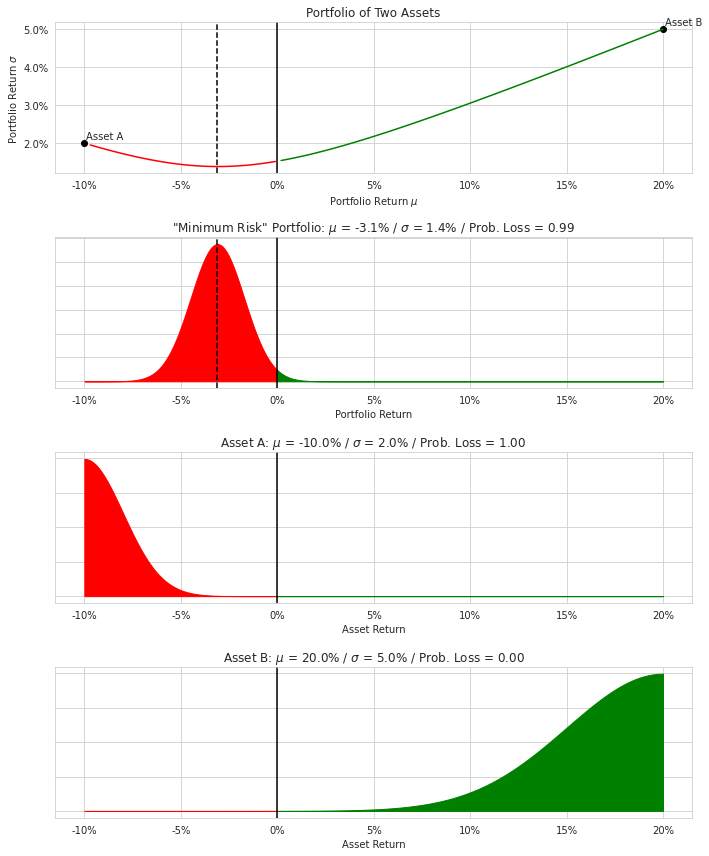

In [62]:
# Filename for the plot.
filename = 'Variance is NOT Risk - Min Risk Portfolio.svg'

# Names of the two assets.
names = ['Asset A', 'Asset B']

# Means of the two assets.
mean = np.array([-0.1, 0.2])

# Std.dev. of the two assets.
std = np.array([0.02, 0.05])

# Correlation of the two assets.
corr = np.array([[1.0, -0.5],
                 [-0.5, 1.0]])

# Plot and save it.
plot_two_assets(mean=mean, std=std, corr=corr,
                names=names, filename=filename);

## Naive Forecasting

Plot rolling statistics for stock-returns to show that "naive" forecasting doesn't work. We cannot simply assume that the recent past will repeat in the future. Instead we need to use "conditional" probability distributions where the observation of some other signal-values can be used to forecast the future, as shown further below.

In [63]:
# String constants used as names in these plots.
WINDOW_LENGTH = 'Window Length'
MEAN_RETURN = 'Mean Daily Return'
STD_RETURN = 'Std.Dev. Daily Return'
CORR = 'Correlation'
TICKER2 = TICKER + '2'
TICKER_PAIR = 'Ticker Pair'

In [64]:
def calc_rolling_stats(returns, tickers, windows):
    """
    Calculate rolling statistics for stock-returns.
    
    :param returns:
        Pandas DataFrame with stock-returns. The columns are
        for the individual stocks and the rows are for time-steps.

    :param tickers:
        List of strings for stock-tickers.
    
    :param windows:
        List of integers with window-lengths.

    :return:
        df_mean: Pandas DataFrame with rolling means.
        df_std: Pandas DataFrame with rolling std.dev.
        df_corr: Pandas DataFrame with rolling correlations.
    """
    # List with unique combinations of stock-tickers.
    ticker_pairs = list(combinations(tickers, r=2))

    # Names for window-lengths used in plotting.
    names = [str(window) + ' Days' for window in windows]

    # Get returns for the given tickers.
    rets = returns[tickers]

    # Init lists with results.
    list_mean = []
    list_std = []
    list_corr = []

    # For each window-length and its string-name.
    for window, name in zip(windows, names):
        # Calculate rolling statistics.
        mean = rets.rolling(window=window).mean().stack().rename(name)
        std = rets.rolling(window=window).std().stack().rename(name)
        corr = rets.rolling(window=window).corr().stack().rename(name)

        # Fix the correlation has two index-columns named TICKER.
        corr.index.rename([DATE, TICKER, TICKER2], inplace=True)

        # Store the results for later use.
        list_mean.append(mean)
        list_std.append(std)
        list_corr.append(corr)

    # Convert to Pandas DataFrames.
    df_mean = pd.concat(list_mean, axis=1).dropna()
    df_std = pd.concat(list_std, axis=1).dropna()
    df_corr = pd.concat(list_corr, axis=1).dropna()

    # Convert mean to DataFrame that can be plotted by Seaborn.
    id_vars = [DATE, TICKER]
    df_mean = df_mean.reset_index().melt(id_vars=id_vars,
                                         var_name=WINDOW_LENGTH,
                                         value_name=MEAN_RETURN)

    # Convert std.dev. to DataFrame that can be plotted by Seaborn.
    df_std = df_std.reset_index().melt(id_vars=id_vars,
                                       var_name=WINDOW_LENGTH,
                                       value_name=STD_RETURN)

    # Combine two index columns with tickers into a single ticker-pair.
    df_corr = df_corr.reset_index()
    df_corr[TICKER_PAIR] = list(zip(df_corr[TICKER], df_corr[TICKER2]))
    df_corr = df_corr.drop(columns=[TICKER, TICKER2])

    # Only use rows that have relevant ticker-pairs.
    mask = df_corr[TICKER_PAIR].isin(ticker_pairs)
    df_corr = df_corr.loc[mask]

    # Convert corr. to DataFrame that can be plotted by Seaborn.
    df_corr = df_corr.melt(id_vars=[DATE, TICKER_PAIR],
                           var_name=WINDOW_LENGTH, value_name=CORR)

    return df_mean, df_std, df_corr

In [65]:
def plot_rolling_stats(df, stat_name, tickers, windows,
                       col_ticker=TICKER, y_dashed_line=None):
    """
    Plot rolling statistics for multiple stock-tickers or
    ticker-pairs. Each ticker or ticker-pair has its separate
    sub-plot on an individual row.
    
    :param df:
        Pandas DataFrame with data to be plotted.
        Generated by the function `calc_rolling_stats`.
        
    :param stat_name:
        String with name for the statistic.
        
    :param tickers:
        List of strings for stock-tickers.
    
    :param windows:
        List of integers with window-lengths.
        
    :param col_ticker:
        String with name of column in `df` used to plot
        different rows. E.g. TICKER or TICKER_PAIR.
        
    :param y_dashed_line:
        If not `None` then plot a horizontal black dashed
        line at this value.
        
    :return:
        Matplotlib Axis object.
    """
    # Plot the rolling statistics in sub-plots for each ticker.
    facet_kws = {'sharey': False, 'sharex': True}
    g = sns.relplot(x=DATE, y=stat_name, hue=WINDOW_LENGTH,
                    row=col_ticker, data=df, kind='line',
                    facet_kws=facet_kws, height=4, aspect=10/4)

    # Add a horizontal black dashed line?
    if y_dashed_line is not None:
        for ax in g.axes:
            # Plot dashed black line to indicate regions of loss vs. gain.
            ax[0].axhline(y=y_dashed_line, color='black', linestyle='dashed')

    # Adjust padding.
    g.tight_layout()

    # Save plot to a file.
    tickers_str = ', '.join(tickers)
    windows_str = ', '.join(map(str, windows))
    filename = f'Rolling {stat_name} ({tickers_str}) (Windows {windows_str})'
    filename = filename.replace('.', '')
    filename = filename + '.svg'
    filename = os.path.join(path_plots, filename)
    g.savefig(filename, bbox_inches='tight')

    return g

In [66]:
def calc_plot_rolling_stats(returns, tickers, windows):
    """
    First calculate the rolling statistics and then plot them.
    
    :param returns:
        Pandas DataFrame with stock-returns. The columns are
        for the individual stocks and the rows are for time-steps.

    :param tickers:
        List of strings for stock-tickers.
    
    :param windows:
        List of integers with window-lengths.

    :return:
        `None`
    """
    # Calculate the rolling statistics.
    df_mean, df_std, df_corr = \
        calc_rolling_stats(returns=returns, tickers=tickers, windows=windows)
    
    # Plot the rolling means.
    plot_rolling_stats(df=df_mean, stat_name=MEAN_RETURN,
                       col_ticker=TICKER, tickers=tickers,
                       windows=windows, y_dashed_line=1.0)

    # Plot the rolling std.dev.
    plot_rolling_stats(df=df_std, stat_name=STD_RETURN,
                       col_ticker=TICKER, tickers=tickers,
                       windows=windows, y_dashed_line=0.0)

    # Plot the rolling correlations.
    plot_rolling_stats(df=df_corr, stat_name=CORR,
                       col_ticker=TICKER_PAIR, tickers=tickers,
                       windows=windows, y_dashed_line=0.0)    

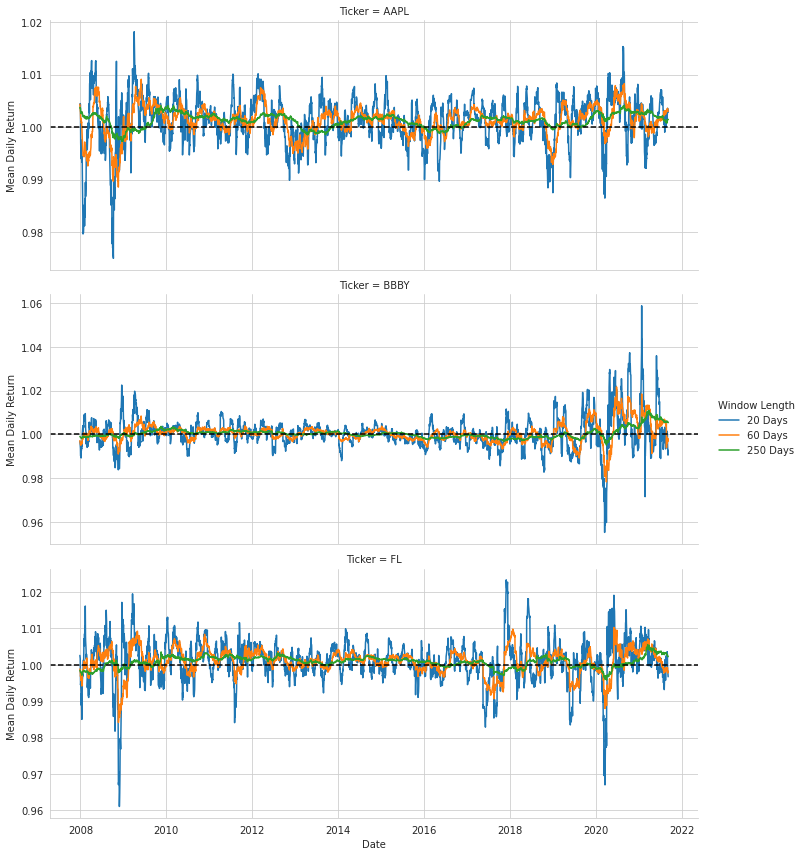

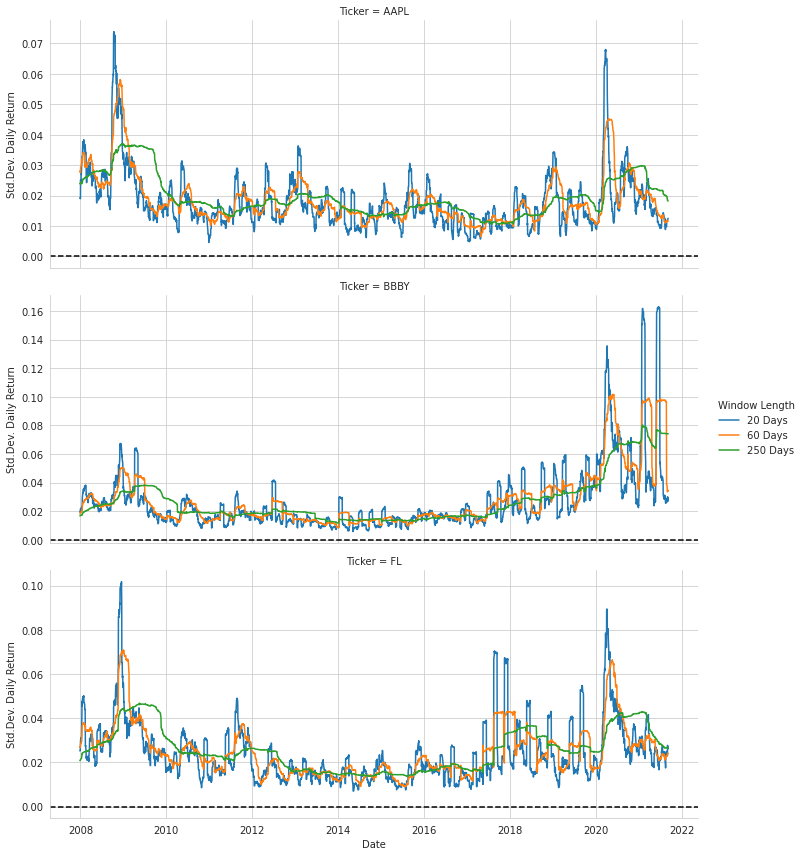

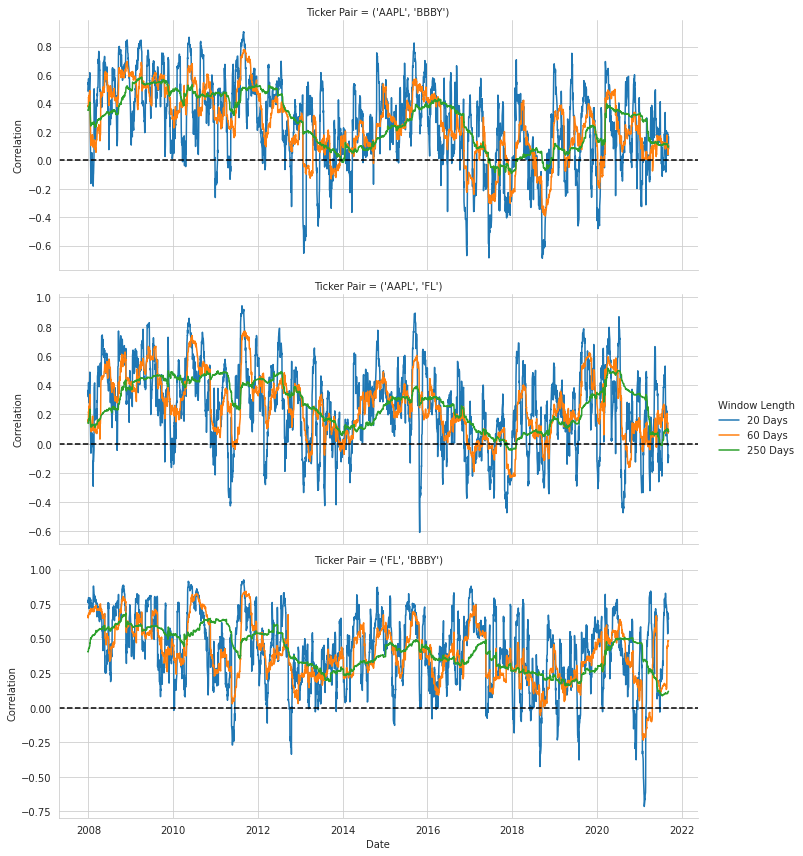

In [67]:
tickers = ['AAPL', 'FL', 'BBBY']
windows = [20, 60, 250]

calc_plot_rolling_stats(returns=daily_returns,
                       tickers=tickers, windows=windows)

## Conditional Forecasting

In [68]:
def plot_psales_vs_return(ticker, figsize=figsize_big):
    """
    Plot comparison of the P/Sales valuation ratio versus
    the future daily returns and the future long-term returns
    e.g. for 2-3 year investment periods.
    
    The future long-term returns are converted from annualized
    returns to daily returns, so they can be compared on the
    same scale.
    
    The plots typically show that the P/Sales ratio is a good
    predictor for long-term stock returns, but the relation is
    completely hidden by day-to-day noise.
    
    :param ticker: String with the stock-ticker.
    :param figsize: Tuple with the figure-size.
    :return: Matplotlib Axis object.
    """
    # P/Sales ratios.
    psales = df_val_signals.loc[ticker, PSALES]
    
    # Daily returns.
    daily_rets = daily_returns[ticker]
    
    # Future long-term returns.
    future_rets = future_mean_ann_returns[ticker]
    # Convert long-term annualized returns to daily returns.
    future_rets = (future_rets + 1.0) ** (1.0/BDAYS_PER_YEAR)

    # Convert to Pandas DataFrame.
    data = \
    {
        PSALES: psales,
        DAILY_RETURN: daily_rets,
        FUTURE_RETURN: future_rets
    }
    df = pd.DataFrame(data).dropna()
    
    # Create new figure.
    fig, axs = plt.subplots(nrows=3, squeeze=True, figsize=figsize)
    
    # Title.
    title = f'Compare P/Sales vs. Future Daily and Long-Term Returns ({ticker})'

    # Note: The lines are rasterized (turned into pixels) to
    # save space when saving to vectorized graphics-file.

    # Plot P/Sales vs. Long-Term Returns.
    df.plot(kind='scatter', x=PSALES, y=FUTURE_RETURN, title=title,
            color='blue', rasterized=True, ax=axs[0]);
    
    # Plot P/Sales vs. Daily Return.
    df.plot(kind='scatter', x=PSALES, y=DAILY_RETURN, color='green',
            rasterized=True, ax=axs[1]);

    # Plot P/Sales vs. Daily AND Long-Term Returns.
    df.plot(kind='scatter', x=PSALES, y=DAILY_RETURN, color='green',
            rasterized=True, ax=axs[2]);
    df.plot(kind='scatter', x=PSALES, y=FUTURE_RETURN, color='blue',
            rasterized=True, ax=axs[2]);
    
    # Adjust axis-labels etc.
    for ax in axs[0:2]:
        ax.set_xlabel(None)
        ax.tick_params(axis='x', which='both', top=False,
                       bottom=False, labelbottom=False)
    axs[2].set_ylabel('Daily AND ' + FUTURE_RETURN)
    
    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk.
    filename = title.replace('/', '')
    filename = os.path.join(path_plots, filename + '.svg')
    fig.savefig(filename, bbox_inches='tight')

    return fig

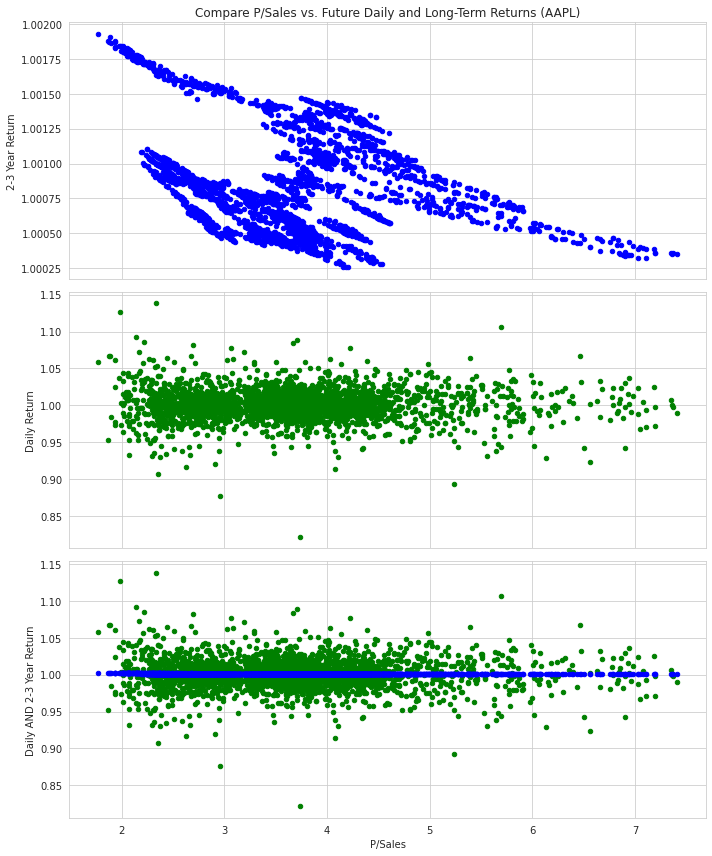

In [69]:
plot_psales_vs_return(ticker='AAPL');

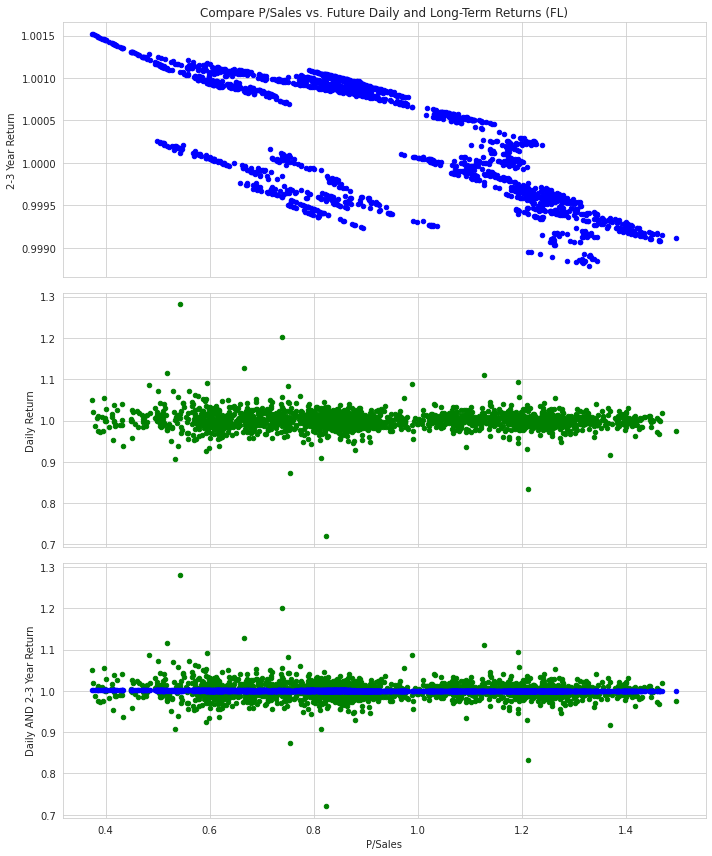

In [70]:
plot_psales_vs_return(ticker='FL');

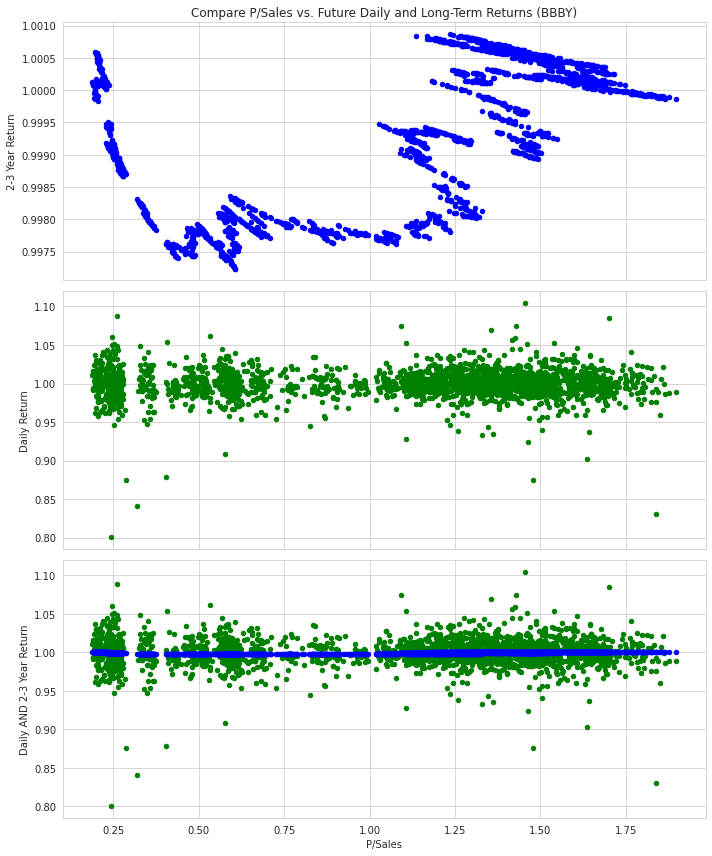

In [71]:
plot_psales_vs_return(ticker='BBBY');

## Random Walks

In [72]:
def sim_plot_random_walks(ticker, returns, look_ahead,
                          num_trials=100, figsize=figsize_mid):
    """
    Simulate and plot Random and Semi-Random Walk of stock-prices.
    
    In the Random Walks, the daily stock-returns are IID
    (Independent and Identically Distributed) using a normal
    distribution with mean and standard deviation of the
    actual stock-returns. This can create a very wide range of
    simulated share-prices which is un-natural.
    
    In the Semi-Random Walks, the daily stock-returns are also
    normal distributed using the standard deviation of the
    actual stock-returns, but the means are calculated from
    the last simulated stock-price and the actual stock-price
    e.g. 1 year into the future. This results in a Random Walk
    in the short-term, but the simulated share-price does not
    move too far away from the actual share-price. This is more
    natural and more in line with how we think about long-term
    investing: We are trying to predict long-term stock-returns
    from a company's future growth and change in valuation ratio,
    and we are usually unable to predict short-term randomness.
    
    Note that the random numbers are the same for both the
    Random and Semi-Random Walks, we are just shifting the mean
    for the Semi-Random Walks. This gives an accurate comparison
    of the difference between the two methods.
    
    :param ticker:
        String with the stock-ticker to use.
        
    :param returns:
        Pandas DataFrame with e.g. daily returns for all stocks.
        Rows are the time-steps. Columns are stock-tickers.

    :param look_ahead:
        Integer with the number of years to look-ahead for the
        Semi-Random Walks.
        
    :param num_trials:
        Integer with the number of random walks to simulate.
    
    :param figsize:
        Tuple with the figure-size.
        
    :return:
        Matplotlib Axis object.
    """
    # Get returns for the given stock-ticker and remove empty rows.
    rets = returns[ticker].dropna()

    # Number of time-steps.
    num_steps = len(rets)

    # Actual stock-prices, normalized to start at 1.
    prices = rets.cumprod()

    # Mean and std.dev. for the actual stock-returns.
    mu = rets.mean()
    sigma = rets.std()

    # Shape of simulated 2-dim arrays.
    # Rows are time-steps. Columns are trials.
    shape = (num_steps, num_trials)

    # Init. array of simulated stock-prices.
    # First row is 1.0 and all other rows are NaN.
    init = np.ones(shape=shape, dtype=float)
    init[1:, :] = np.nan
    
    # Create new DataFrames with simulated stock-prices.
    # The init-array is copied so we don't use the same instance.
    sim_prices1 = pd.DataFrame(data=init.copy(), index=rets.index)
    sim_prices2 = pd.DataFrame(data=init.copy(), index=rets.index)

    # Convert the look-ahead from years to days.
    look_ahead_days = int(look_ahead * BDAYS_PER_YEAR)

    # Standard-normal random numbers used as the basis for
    # the simulated stock-returns. These numbers are used
    # for both the Random and Semi-Random Walks.
    x = rng.normal(loc=0.0, scale=1.0, size=shape)

    # For each time-step.
    for t in range(num_steps - look_ahead_days):
        # Simulated returns for the Random Walks.
        r1 = x[t, :] * sigma + mu
        
        # Update the simulated stock-prices for the Random Walks.
        sim_prices1.iloc[t+1] = r1 * sim_prices1.iloc[t]

        # Simulated returns for the Semi-Random Walks.
        # The mean is now calculated from the actual share-price
        # e.g. 1 year into the future, and the last simulated
        # share-price.
        mu_t = (prices.iloc[t + look_ahead_days] / sim_prices2.iloc[t]) ** (1.0/BDAYS_PER_YEAR)
        r2 = x[t, :] * sigma + mu_t
        
        # Update the simulated stock-prices for the Semi-Random Walks.
        sim_prices2.iloc[t+1] = r2 * sim_prices2.iloc[t]

    # Create new plot.
    fig, ax = plt.subplots(figsize=figsize)

    # Set plot's title.
    title = f'Random & Semi-Random Walks ' + \
            f'({ticker}, {look_ahead} Year Look-Ahead, ' + \
            f'{num_trials} Trials)'
    ax.set_title(title)

    # Note: The lines are rasterized (turned into pixels) to
    # save space when saving to vectorized graphics-file.

    # Plot the simulated Random Walks.
    sim_prices1.plot(legend=False, color='blue', alpha=0.1,
                     logy=True, rasterized=True, ax=ax)

    # Plot the simulated Semi-Random Walks.
    sim_prices2.plot(legend=False, color='green', alpha=0.1,
                     logy=True, rasterized=True, ax=ax)
    
    # Plot the original share-price normalized to start at 1.
    prices.plot(color='red', rasterized=True, ax=ax)

    # Create a custom legend for the plot.
    handles = [Line2D([0], [0], label='Random Walks', color='blue'),
               Line2D([0], [0], label='Semi-Random Walks', color='green'),
               Line2D([0], [0], label='Actual Share-Price', color='red')]
    ax.legend(handles=handles)
    
    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk.
    filename = os.path.join(path_plots, title + '.svg')
    fig.savefig(filename, bbox_inches='tight')

    return fig

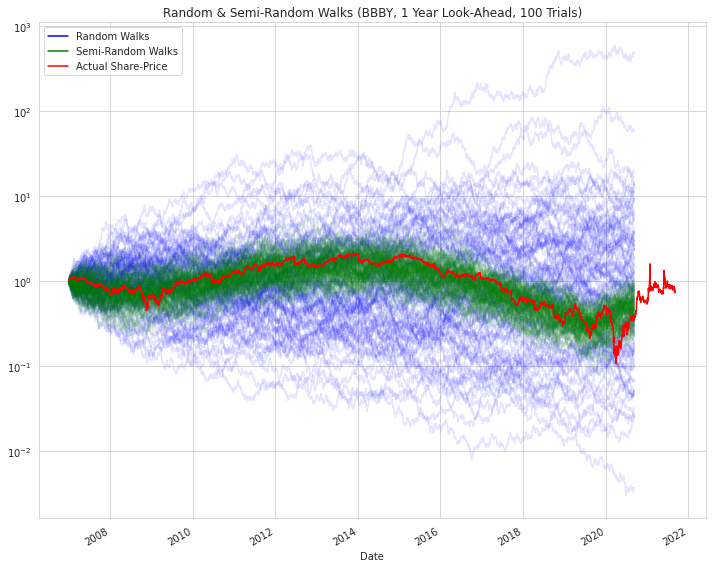

In [73]:
sim_plot_random_walks(ticker='BBBY', look_ahead=1,
                      returns=daily_returns);

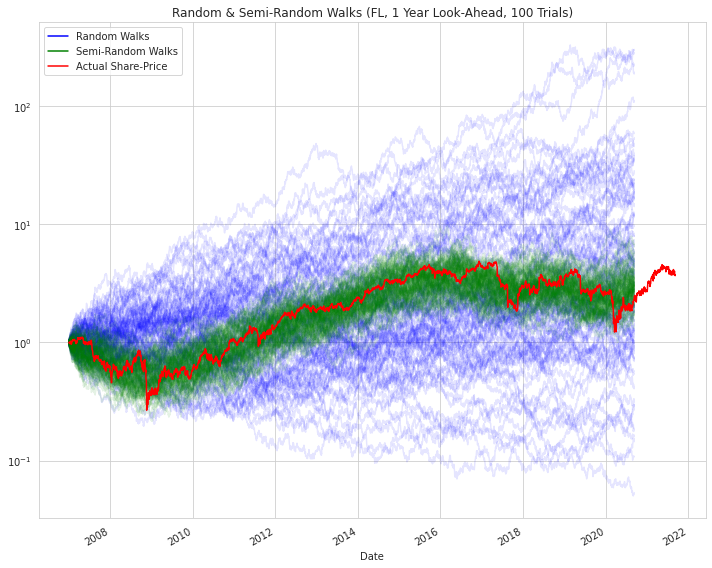

In [74]:
sim_plot_random_walks(ticker='FL', look_ahead=1,
                      returns=daily_returns);

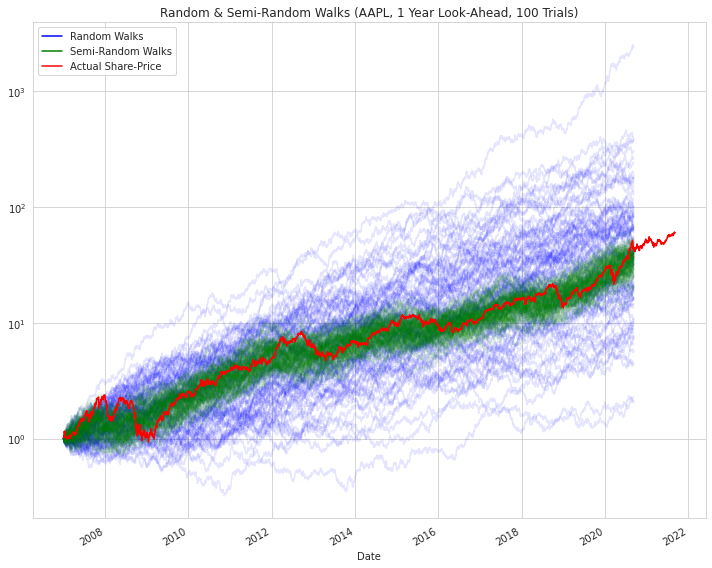

In [75]:
sim_plot_random_walks(ticker='AAPL', look_ahead=1,
                      returns=daily_returns);

## Filter Methods

In [76]:
def plot_linear_filter(mu_min=0.1, mu_max=0.3, weight_max=0.1,
                       step=0.01, color='black', filename=None):
    """
    Plot the linear filter for creating portfolio weights
    and save it to a file.
    
    :param mu_min: Lowest value for the mean return.
    :param mu_max: Highest value for the mean return.
    :param weight_max: Highest value for the portfolio weight.
    :param step: Stepsize for generating points in plot.
    :param color: Color of the plot-line.
    :param filename: String with filename for saving plot.
    :return: Matplotlib Axis object.
    """
    
    # Parameters for the linear function y = a * x + b
    a = weight_max / (mu_max - mu_min)
    b = -a * mu_min
    
    # First piece of the line for mu_min < x
    x1 = np.arange(0, mu_min, step=step)
    y1 = np.zeros(len(x1))

    # Second piece of the line for mu_min < x < mu_max
    x2 = np.arange(mu_min, mu_max, step=step)
    y2 = a * x2 + b

    # Third piece of the line for mu_max < x
    x3 = np.arange(mu_max, mu_max + mu_min, step=step)
    y3 = weight_max * np.ones(len(x3))

    # Combine the line pieces.
    x = np.concatenate([x1, x2, x3])
    y = np.concatenate([y1, y2, y3])

    # Create new figure.
    fig, ax = plt.subplots(figsize=figsize_small)

    # Plot the lines.
    ax.plot(x, y, color=color);

    # Change y-axis ticks and labels.
    ax.set_yticks([0, weight_max])
    ax.set_yticklabels(['0', '$Weight_{max}$'])

    # Change x-axis ticks and labels.
    ax.set_xticks([0, mu_min, mu_max, mu_min+mu_max])
    ax.set_xticklabels(['0', '$\mu_{min}$', '$\mu_{max}$', ''])

    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk.
    if filename is not None:
        filename = os.path.join(path_plots, filename)
        fig.savefig(filename, bbox_inches='tight')

    return fig

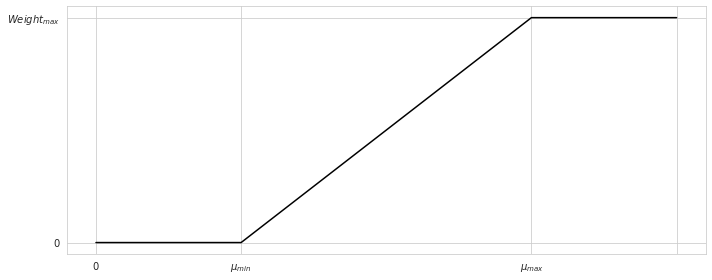

In [77]:
filename = 'Filter Linear.svg'
plot_linear_filter(filename=filename);

## Diversification Examples

In [78]:
def log_weights(weights_org, corr, weights_guess=None, filename=None, tol=1e-4):
    """
    Run the algorithm for diversifying the portfolio weights
    and show the log of adjusted weights and their Full Exposure.
    
    :param weights_org:
        Array with the originally desired portfolio weights.

    :param corr:
        Matrix of floats with the correlation-matrix.
    
    :param weights_guess:
        Array with the initial guess for the adjusted weights.

    :param filename:
        String with filename for writing the table in a CSV-file.
        It will be saved in the same path as the plots.
    
    :param tol:
        Stop the diversification algorithm when asset-weight
        adjustments are smaller than this tolerance level.

    :return:
        - Pandas DataFrame with the weights and Full Exposure.
        - Pandas DataFrame with changes for each iteration.
    """
    # Initialize the log of updated portfolio weights.
    log = []

    # Run the diversification algorithm.
    diversify.adjust_weights(weights_org=weights_org,
                             weights_guess=weights_guess,
                             corr=corr, log=log, tol=tol)

    # Convert the log to a Pandas DataFrame.
    df = diversify.log_to_dataframe(weights_org=weights_org,
                                    corr=corr, log=log)
    
    # Calculate the multiplicative changes for each iteration.
    df_chg = df.pct_change() + 1.0
    
    # Save table to a CSV-file?
    if filename is not None:
        # Save weights and Full Exposure to a CSV-file.
        path = os.path.join(path_plots, filename + '.csv')
        df.to_csv(path)
    
        # Save the changes to a CSV-file.
        path = os.path.join(path_plots, filename + ' Change.csv')
        df.to_csv(path)

    # Display DataFrames.
    display(df)
    display(df_chg)
        
    return df, df_chg

In [79]:
weights_org = np.array([0.09, 0.12])
corr = np.array([[1.0, 0.5],
                 [0.5, 1.0]])

filename = 'Diversify Example 0'
_ = log_weights(weights_org=weights_org, corr=corr, filename=filename)

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2           MSE
Iteration                                                            
0          0.090000     0.103923  0.120000     0.130767  1.548894e-04
1          0.076241     0.089026  0.110848     0.120000  4.747515e-07
2          0.077204     0.089988  0.110737     0.120000  7.056190e-11
3          0.077216     0.090000  0.110736     0.120000  1.048103e-14

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2       MSE
Iteration                                                        
0               NaN          NaN       NaN          NaN       NaN
1          0.847127     0.856649  0.923731     0.917663  0.003065
2          1.012630     1.010812  0.999001     1.000000  0.000149
3          1.000152     1.000130  0.999988     1.000000  0.000149

In [80]:
weights_org = np.array([-0.09, 0.12])
corr = np.array([[1.0, 0.5],
                 [0.5, 1.0]])

filename = 'Diversify Example 1'
_ = log_weights(weights_org=weights_org, corr=corr, filename=filename)

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2  MSE
Iteration                                                   
0             -0.09        -0.09      0.12         0.12  0.0
1             -0.09        -0.09      0.12         0.12  0.0

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2  MSE
Iteration                                                   
0               NaN          NaN       NaN          NaN  NaN
1               1.0          1.0       1.0          1.0  NaN

In [81]:
weights_org = np.array([-0.09, 0.12])
corr = np.array([[1.0, -0.5],
                 [-0.5, 1.0]])

filename = 'Diversify Example 2'
_ = log_weights(weights_org=weights_org, corr=corr, filename=filename)

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2           MSE
Iteration                                                            
0         -0.090000    -0.103923  0.120000     0.130767  1.548894e-04
1         -0.076241    -0.089026  0.110848     0.120000  4.747515e-07
2         -0.077204    -0.089988  0.110737     0.120000  7.056190e-11
3         -0.077216    -0.090000  0.110736     0.120000  1.048103e-14

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2       MSE
Iteration                                                        
0               NaN          NaN       NaN          NaN       NaN
1          0.847127     0.856649  0.923731     0.917663  0.003065
2          1.012630     1.010812  0.999001     1.000000  0.000149
3          1.000152     1.000130  0.999988     1.000000  0.000149

In [82]:
weights_org = np.array([0.10, 0.15, 0.20])
corr = np.array([[1.0, 0.8, 0.5],
                 [0.8, 1.0, 0.2],
                 [0.5, 0.2, 1.0]])

filename = 'Diversify Example 3'
_ = log_weights(weights_org=weights_org, corr=corr, filename=filename)

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2  Weight 3  \
Iteration                                                           
0          0.100000     0.156844  0.150000     0.182483  0.200000   
1          0.050810     0.096302  0.131103     0.149847  0.191228   
2          0.053881     0.099856  0.130406     0.149994  0.190875   
3          0.054002     0.099994  0.130378     0.150000  0.190861   
4          0.054006     0.100000  0.130377     0.150000  0.190860   

           Full Exp. 3           MSE  
Iteration                             
0             0.214942  1.503207e-03  
1             0.200000  4.566504e-06  
2             0.200000  6.930635e-09  
3             0.200000  1.053565e-11  
4             0.200000  1.599250e-14

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2  Weight 3  \
Iteration                                                           
0               NaN          NaN       NaN          NaN       NaN   
1          0.508103     0.613998  0.874018     0.821154  0.956139   
2          1.060436     1.036905  0.994683     1.000983  0.998154   
3          1.002235     1.001386  0.999792     1.000039  0.999928   
4          1.000087     1.000054  0.999992     1.000002  0.999997   

           Full Exp. 3       MSE  
Iteration                         
0                  NaN       NaN  
1             0.930484  0.003038  
2             1.000000  0.001518  
3             1.000000  0.001520  
4             1.000000  0.001518

In [83]:
weights_org = np.array([-0.10, 0.15, 0.20])
corr = np.array([[1.0, -0.8, 0.5],
                 [-0.8, 1.0, 0.2],
                 [0.5, 0.2, 1.0]])

filename = 'Diversify Example 4'
_ = log_weights(weights_org=weights_org, corr=corr, filename=filename)

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2  Weight 3  \
Iteration                                                           
0         -0.100000    -0.140000  0.150000     0.182483  0.200000   
1         -0.062923    -0.095424  0.127794     0.149957  0.197460   
2         -0.067144    -0.099766  0.126706     0.150000  0.197482   
3         -0.067361    -0.099987  0.126648     0.150000  0.197483   
4         -0.067373    -0.099999  0.126645     0.150000  0.197483   

           Full Exp. 3           MSE  
Iteration                             
0             0.202978  8.880016e-04  
1             0.200000  6.980602e-06  
2             0.200000  1.826006e-08  
3             0.200000  5.235536e-11  
4             0.200000  1.501251e-13

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2  Weight 3  \
Iteration                                                           
0               NaN          NaN       NaN          NaN       NaN   
1          0.629234     0.681600  0.851959     0.821758  0.987302   
2          1.067083     1.045502  0.991486     1.000291  1.000109   
3          1.003230     1.002220  0.999541     0.999998  1.000006   
4          1.000172     1.000119  0.999975     1.000000  1.000000   

           Full Exp. 3       MSE  
Iteration                         
0                  NaN       NaN  
1             0.985329  0.007861  
2             1.000000  0.002616  
3             1.000000  0.002867  
4             1.000000  0.002867

In [84]:
weights_org = np.array([-0.10, 0.15, -0.20])
corr = np.array([[1.0, -0.8, 0.5],
                 [-0.8, 1.0, -0.2],
                 [0.5, -0.2, 1.0]])

filename = 'Diversify Example 5'
_ = log_weights(weights_org=weights_org, corr=corr, filename=filename)

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2  Weight 3  \
Iteration                                                           
0         -0.100000    -0.156844  0.150000     0.182483 -0.200000   
1         -0.050810    -0.096302  0.131103     0.149847 -0.191228   
2         -0.053881    -0.099856  0.130406     0.149994 -0.190875   
3         -0.054002    -0.099994  0.130378     0.150000 -0.190861   
4         -0.054006    -0.100000  0.130377     0.150000 -0.190860   

           Full Exp. 3           MSE  
Iteration                             
0            -0.214942  1.503207e-03  
1            -0.200000  4.566504e-06  
2            -0.200000  6.930635e-09  
3            -0.200000  1.053565e-11  
4            -0.200000  1.599250e-14

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2  Weight 3  \
Iteration                                                           
0               NaN          NaN       NaN          NaN       NaN   
1          0.508103     0.613998  0.874018     0.821154  0.956139   
2          1.060436     1.036905  0.994683     1.000983  0.998154   
3          1.002235     1.001386  0.999792     1.000039  0.999928   
4          1.000087     1.000054  0.999992     1.000002  0.999997   

           Full Exp. 3       MSE  
Iteration                         
0                  NaN       NaN  
1             0.930484  0.003038  
2             1.000000  0.001518  
3             1.000000  0.001520  
4             1.000000  0.001518

In [85]:
weights_org = np.array([0.10, 0.15, 0.20])
weights_guess = -weights_org
corr = np.array([[1.0, 0.8, 0.5],
                 [0.8, 1.0, 0.2],
                 [0.5, 0.2, 1.0]])

filename = 'Diversify Example 6'
_ = log_weights(weights_org=weights_org, weights_guess=weights_guess,
                corr=corr, filename=filename)

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2  Weight 3  \
Iteration                                                           
0         -0.100000    -0.156844 -0.150000    -0.182483 -0.200000   
1          0.050810     0.099356  0.146053     0.165074  0.200000   
2          0.051333     0.096906  0.130958     0.149846  0.191168   
3          0.053905     0.099884  0.130400     0.149995  0.190872   
4          0.054003     0.099995  0.130378     0.150000  0.190861   
5          0.054006     0.100000  0.130377     0.150000  0.190860   

           Full Exp. 3           MSE  
Iteration                             
0            -0.214942  1.162301e-01  
1             0.209067  1.032833e-04  
2             0.200000  3.199338e-06  
3             0.200000  4.514967e-09  
4             0.200000  6.762986e-12  
5             0.200000  1.023606e-14

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2  Weight 3  \
Iteration                                                           
0               NaN          NaN       NaN          NaN       NaN   
1         -0.508103    -0.633472 -0.973689    -0.904600 -1.000000   
2          1.010284     0.975337  0.896644     0.907748  0.955841   
3          1.050113     1.030730  0.995739     1.000995  0.998451   
4          1.001803     1.001119  0.999834     1.000033  0.999941   
5          1.000070     1.000043  0.999994     1.000001  0.999998   

           Full Exp. 3       MSE  
Iteration                         
0                  NaN       NaN  
1            -0.972667  0.000889  
2             0.956632  0.030976  
3             1.000000  0.001411  
4             1.000000  0.001498  
5             1.000000  0.001514

In [86]:
weights_org = np.array([0.10, -0.15, 0.20])
weights_guess = np.array([-1234.56, 5678.90, -9123.45])
corr = np.array([[1.0, -0.8, 0.5],
                 [-0.8, 1.0, -0.2],
                 [0.5, -0.2, 1.0]])

filename = 'Diversify Example 7'
_ = log_weights(weights_org=weights_org, weights_guess=weights_guess,
                corr=corr, filename=filename)

Weight 1  Full Exp. 1     Weight 2  Full Exp. 2     Weight 3  \
Iteration                                                                    
0         -1234.560000 -2971.027328  5678.900000  6229.715483 -9123.450000   
1             0.000002     0.000291    -0.000062    -0.000705     0.200000   
2             0.078063     0.126294    -0.123794    -0.149804     0.188140   
3             0.055129     0.101286    -0.130115    -0.150045     0.190732   
4             0.054052     0.100052    -0.130367    -0.150002     0.190855   
5             0.054008     0.100002    -0.130377    -0.150000     0.190860   

           Full Exp. 3           MSE  
Iteration                             
0         -9387.526187  4.525607e+07  
1             0.200001  1.074363e-02  
2             0.200000  2.304740e-04  
3             0.200000  5.515375e-07  
4             0.200000  8.993786e-10  
5             0.200000  1.382761e-12

Weight 1   Full Exp. 1      Weight 2   Full Exp. 2  Weight 3  \
Iteration                                                                     
0                   NaN           NaN           NaN           NaN       NaN   
1         -1.369326e-09 -9.789634e-08 -1.085673e-08 -1.131761e-07 -0.000022   
2          4.617688e+04  4.342204e+02  2.007869e+03  2.124716e+02  0.940700   
3          7.062165e-01  8.019810e-01  1.051065e+00  1.001608e+00  1.013775   
4          9.804542e-01  9.878202e-01  1.001936e+00  9.997147e-01  1.000648   
5          9.991970e-01  9.995016e-01  1.000075e+00  9.999863e-01  1.000026   

           Full Exp. 3           MSE  
Iteration                             
0                  NaN           NaN  
1            -0.000021  2.373964e-10  
2             0.999993  2.145215e-02  
3             1.000000  2.393058e-03  
4             1.000000  1.630675e-03  
5             1.000000  1.537463e-03

## Convergence Examples

In [87]:
weights_org = np.array([0.08, 0.12])
weights_guess = np.array([0.048756, 1000])
corr = np.array([[1.0, 0.9],
                 [0.9, 1.0]])

filename = 'Convergence Example 1'
_ = log_weights(weights_org=weights_org,
                weights_guess=weights_guess,
                corr=corr, filename=filename)

Weight 1  Full Exp. 1     Weight 2  Full Exp. 2           MSE
Iteration                                                               
0          0.048756     6.284484  1000.000000  1000.019746  4.999190e+05
1          0.000008     0.000876     0.119997     0.120000  3.130274e-03
2          0.045006     0.076065     0.103149     0.120000  7.743853e-06
3          0.048475     0.079708     0.101963     0.120000  4.252045e-08
4          0.048734     0.079978     0.101875     0.120000  2.353525e-10
5          0.048754     0.079998     0.101868     0.120000  1.303387e-12

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2           MSE
Iteration                                                               
0                  NaN          NaN       NaN          NaN           NaN
1             0.000162     0.000139  0.000120      0.00012  6.261562e-09
2          5696.067487    86.794034  0.859598      1.00000  2.473858e-03
3             1.077086     1.047904  0.988501      1.00000  5.490865e-03
4             1.005344     1.003386  0.999138      1.00000  5.535042e-03
5             1.000396     1.000251  0.999936      1.00000  5.538021e-03

In [88]:
weights_org = np.array([0.08, 0.12])
weights_guess = np.array([0.048756, 0.0001])
corr = np.array([[1.0, 0.9],
                 [0.9, 1.0]])

filename = 'Convergence Example 2'
_ = log_weights(weights_org=weights_org,
                weights_guess=weights_guess,
                corr=corr, filename=filename)

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2           MSE
Iteration                                                            
0          0.048756     0.048796  0.000100      0.00199  7.450035e-03
1          0.079960     0.111114  0.091909      0.12000  4.840270e-04
2          0.051013     0.082341  0.101105      0.12000  2.739418e-06
3          0.048923     0.080175  0.101811      0.12000  1.523779e-08
4          0.048768     0.080013  0.101864      0.12000  8.441984e-11
5          0.048756     0.080001  0.101868      0.12000  4.675509e-13

Weight 1  Full Exp. 1    Weight 2  Full Exp. 2       MSE
Iteration                                                          
0               NaN          NaN         NaN          NaN       NaN
1          1.639993     2.277081  919.091884    60.308087  0.064970
2          0.637981     0.741050    1.100058     1.000000  0.005660
3          0.959034     0.973693    1.006979     1.000000  0.005562
4          0.996827     0.997985    1.000517     1.000000  0.005540
5          0.999763     0.999850    1.000038     1.000000  0.005538

In [89]:
weights_org = np.array([0.08, 0.12])
weights_guess = np.array([1000, 0.0001])
corr = np.array([[1.0, 0.9],
                 [0.9, 1.0]])

filename = 'Convergence Example 3'
_ = log_weights(weights_org=weights_org,
                weights_guess=weights_guess,
                corr=corr, filename=filename)

Weight 1  Full Exp. 1  Weight 2  Full Exp. 2           MSE
Iteration                                                               
0          1000.000000  1000.000040  0.000100     0.284605  4.999201e+05
1             0.079960     0.111114  0.091909     0.120000  4.840270e-04
2             0.051013     0.082341  0.101105     0.120000  2.739418e-06
3             0.048923     0.080175  0.101811     0.120000  1.523779e-08
4             0.048768     0.080013  0.101864     0.120000  8.441984e-11
5             0.048756     0.080001  0.101868     0.120000  4.675509e-13

Weight 1  Full Exp. 1    Weight 2  Full Exp. 2           MSE
Iteration                                                              
0               NaN          NaN         NaN          NaN           NaN
1          0.000080     0.000111  919.091884     0.421637  9.682087e-10
2          0.637981     0.741050    1.100058     1.000000  5.659638e-03
3          0.959034     0.973693    1.006979     1.000000  5.562421e-03
4          0.996827     0.997985    1.000517     1.000000  5.540161e-03
5          0.999763     0.999850    1.000038     1.000000  5.538400e-03

## Time-Usage of Diversification Algorithm

Plot the diversification algorithm's average time-usage for different portfolio sizes.

In [90]:
def random_weights_corr(num_assets,
                        weight_scale=0.04,
                        weight_min=-0.1, weight_max=0.1,
                        corr_scale=0.2, corr_max=1):
    """
    Generate random asset-weights and correlation matrix.
    The random numbers are Normal-distributed.
    
    :param num_assets: Number of assets.
    :param weight_scale: Scale for the random weights.
    :param weight_min: Min for the asset-weights.
    :param weight_max: Max for the asset-weights.
    :param corr_scale: Scale for the random correlation coefficients.
    :param corr_max: Max for the absolute correlation coefficients.
    :return:
        weights: Random asset-weights between 0 and weight_max.
        corr: Random correlation matrix between -corr_max and +corr_max.
    """
    # Generate random asset-weights.
    weights = rng.normal(size=num_assets)
    
    # Scale and clip the asset-weights.
    weights = np.clip(weights * weight_scale, weight_min, weight_max)

    # Generate random correlation matrix.
    corr = rng.normal(size=(num_assets, num_assets))
    
    # Scale and clip the correlation matrix.
    corr = np.clip(corr * corr_scale, -corr_max, corr_max)
    
    # Make the correlation matrix symmetric.
    corr = np.triu(corr) + np.tril(corr.T)
    
    # Set the correlation matrix's diagonal to 1.
    np.fill_diagonal(corr, val=1.0)

    return weights, corr

In [91]:
%%time
# Number of assets in each random portfolio.
num_assets = [10, 30, 50, 75, 100, 200, 350, 500, 750,
              1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
              5000, 6000, 7000, 8000, 9000, 10000]

# Minimum number of trials for each portfolio size.
min_trials = 10

# Initialize list of average time-usage.
time_usage = []

# Print status.
print('num_assets=', end='')

for n in num_assets:
    # Print status.
    print(n, end=', ')
    
    # Initialize sum of time-usage.
    sum_time = 0
    
    # Initialize number of random trials performed.
    num_trials = 0

    # Repeat until enough random trials have been performed.
    while num_trials < min_trials or sum_time < 1.0:
        # Generate random portfolio weights and correlations.
        weights_org, corr = \
            random_weights_corr(num_assets=n,
                                weight_scale=0.05, corr_scale=0.4)
        
        # Use diversification algorithm and measure time-usage.
        start_time = time.time()
        diversify.adjust_weights(variant='vec', weights_org=weights_org, corr=corr)
        end_time = time.time()
        
        # Accumulate the overall time-usage.
        sum_time += (end_time - start_time)
        
        # Increase number of trials performed.
        num_trials += 1

    # Average time-usage per trial.
    mean_time = sum_time / num_trials
    
    # Save time-usage for later.
    time_usage.append(mean_time)

num_assets=10, 30, 50, 75, 100, 200, 350, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000, 7000, 8000, 9000, 10000, CPU times: user 3min 30s, sys: 14.1 s, total: 3min 44s
Wall time: 3min 44s


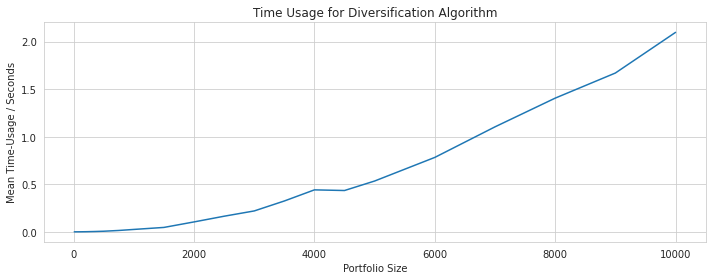

In [92]:
# Create new figure.
fig, ax = plt.subplots(figsize=figsize_small)

# Make line-plot.
ax.plot(num_assets, time_usage);

# Set title and axis-labels.
title = 'Time Usage for Diversification Algorithm'
ax.set_title(title)
ax.set_xlabel('Portfolio Size')
ax.set_ylabel('Mean Time-Usage / Seconds')

# Adjust padding.
fig.tight_layout()

# Save the figure to disk.
filename = os.path.join(path_plots, title + '.svg')
fig.savefig(filename, bbox_inches='tight')

## Test Settings

In [93]:
# Generate random portfolios with this number of stocks.
num_stocks = [5, 10, 30, 50, 70, 100, 150, 200, 300]

# Number of random portfolios to test for each choice of num_stocks.
num_trials = 128

# Time-usage for each test is about 45 min with this configuration,
# when run on a 4-core (8 thread) CPU with 2.6 GHz (3.5 GHz boost).

## Test A - Full Data Period (Omniscient)

In [ ]:
%%time
# Test A: Full Data Period.
sim_plot_all(test_name='Test A',
             returns=daily_returns,
             future_returns=future_mean_ann_returns,
             num_stocks=num_stocks, num_trials=num_trials,
             noise_scale_future_rets=0.0,
             func_adjust_corr=adjust_weights_corr,
             min_return=0.1, max_return=0.5,
             min_weight=0.0, max_weight=0.1)

## Test B - Data Until 2010 (Omniscient)

CPU times: user 1min 1s, sys: 10.2 s, total: 1min 11s
Wall time: 12min 17s


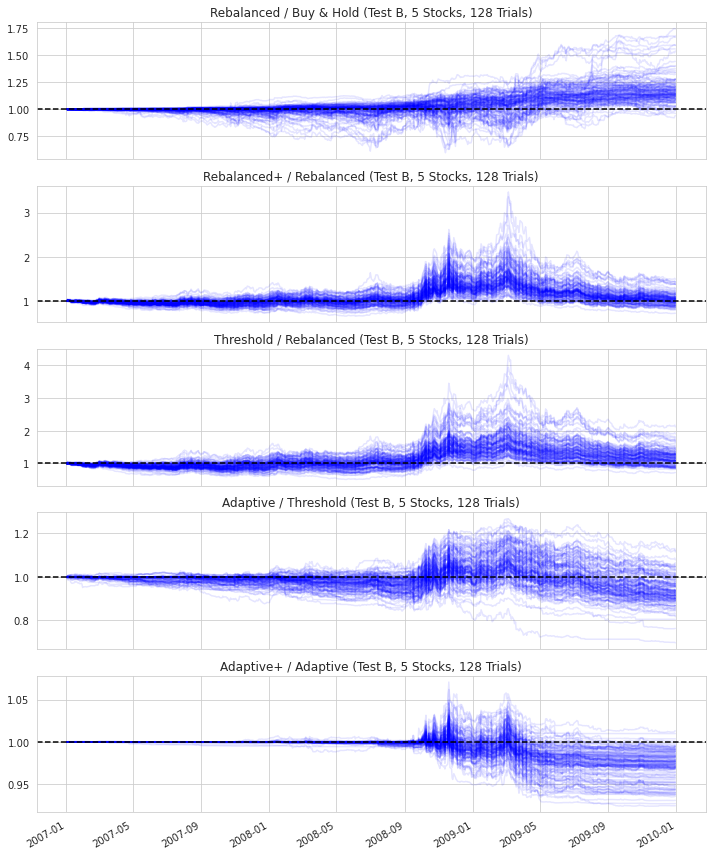

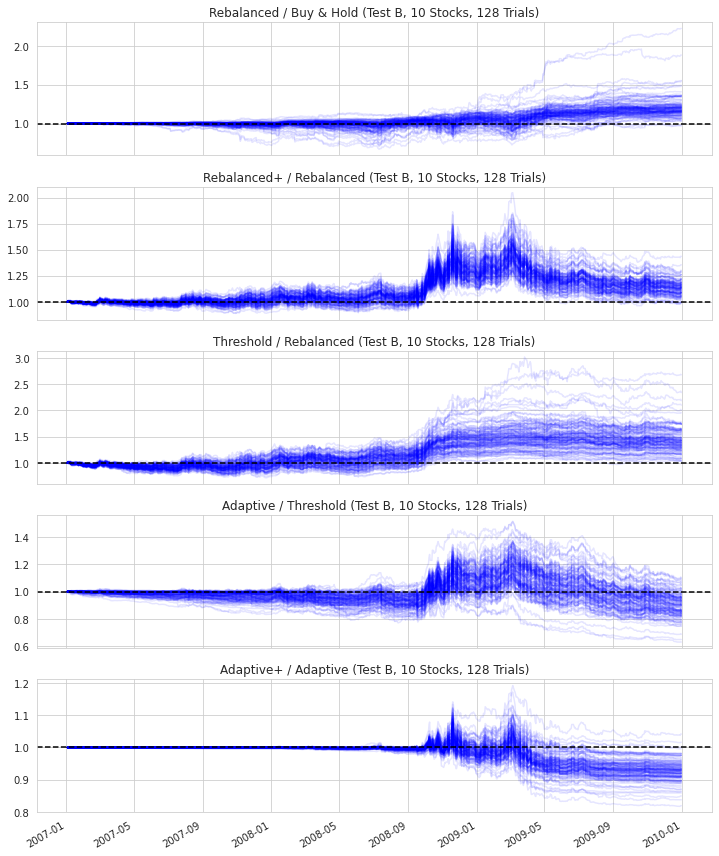

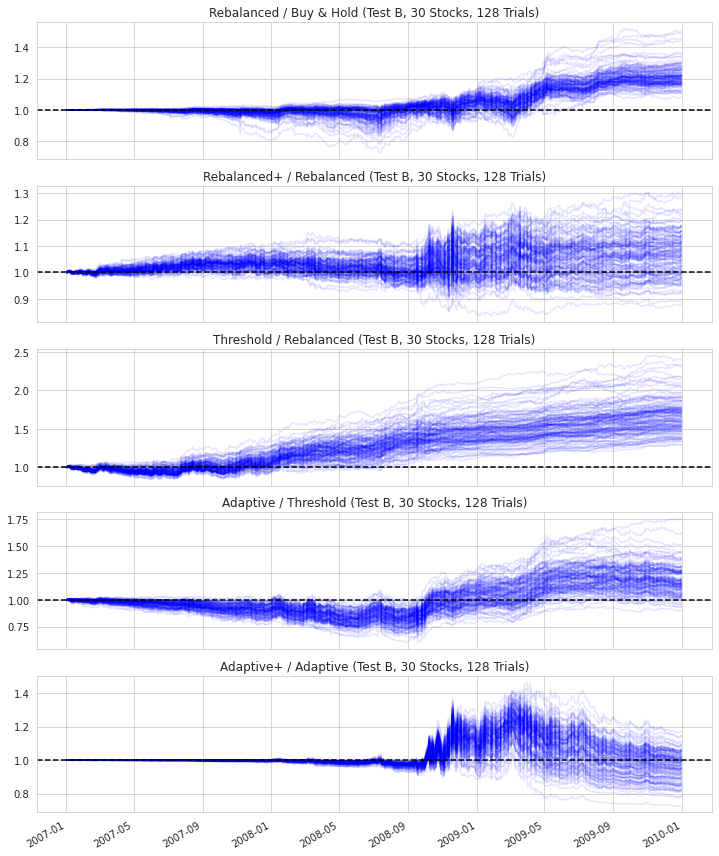

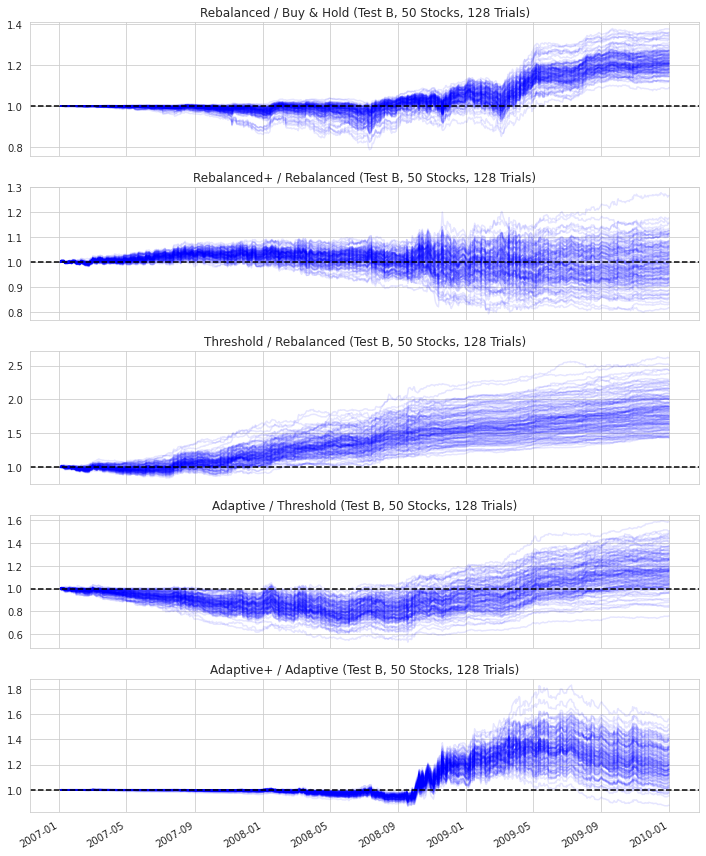

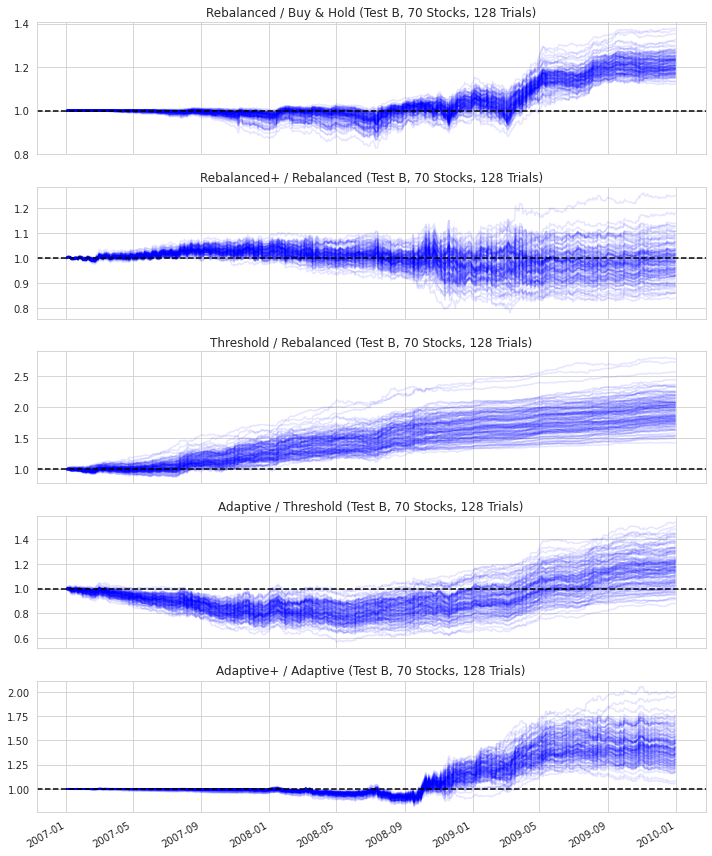

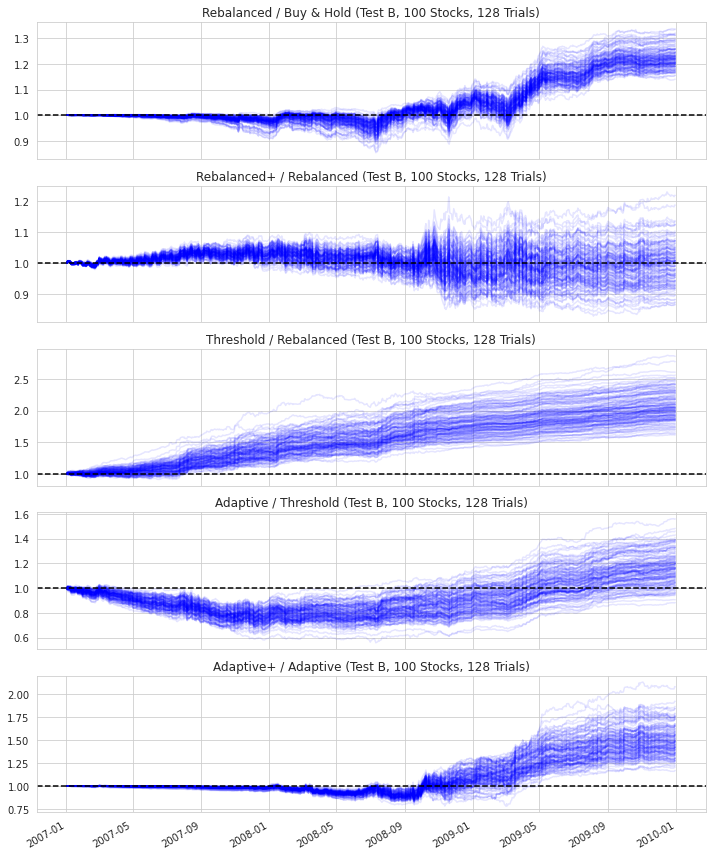

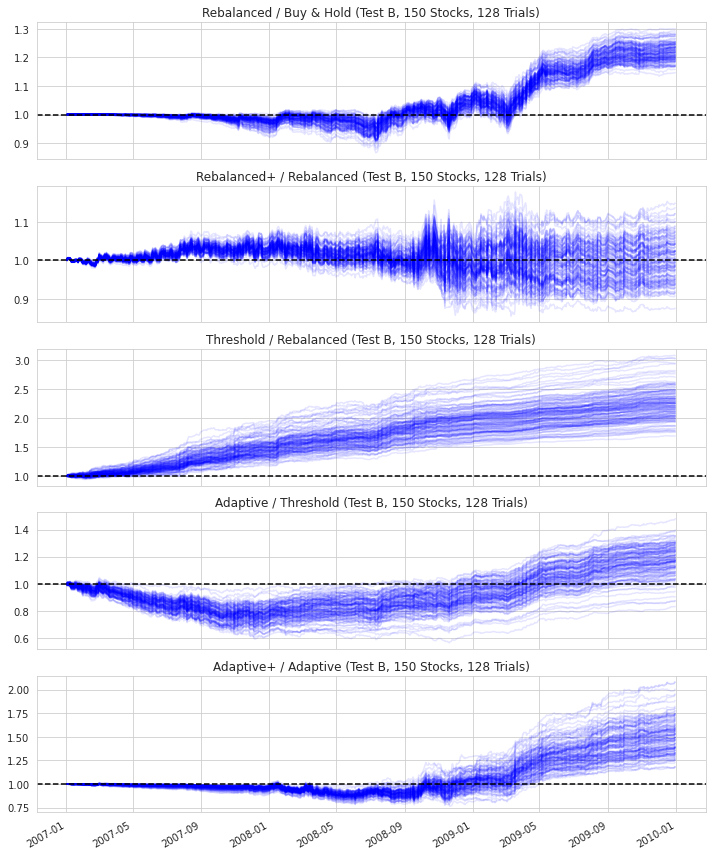

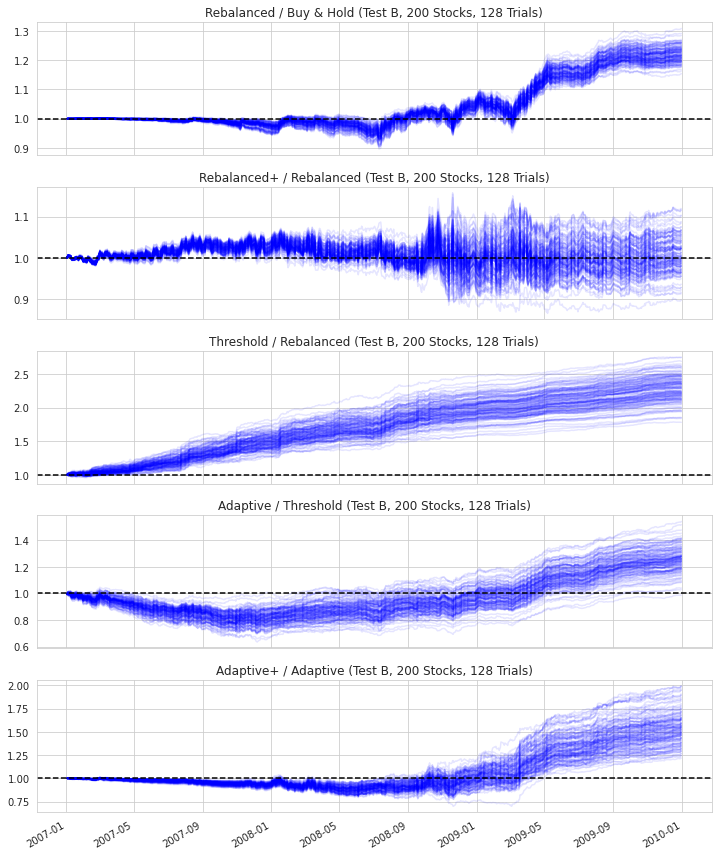

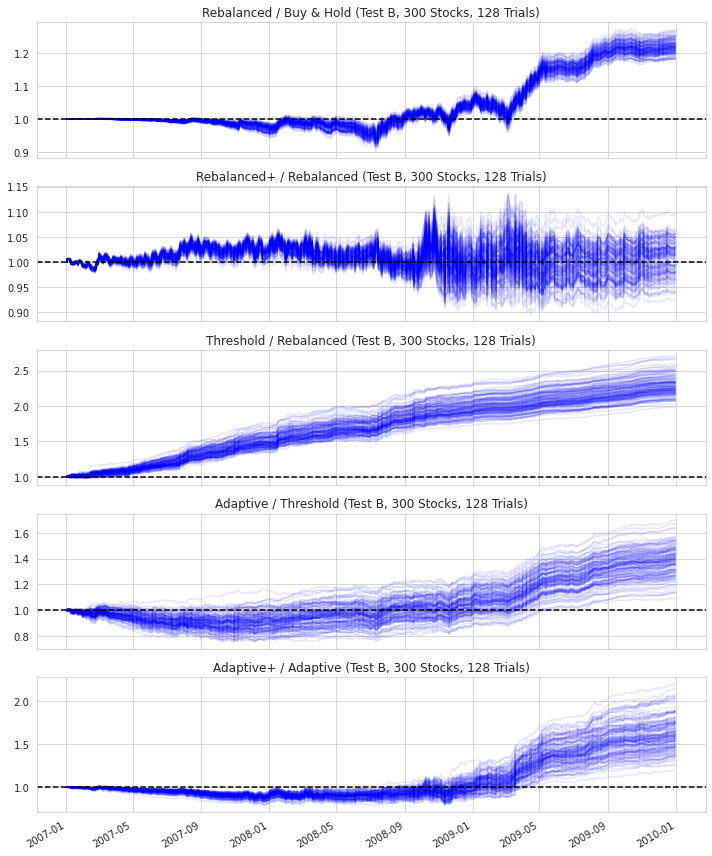

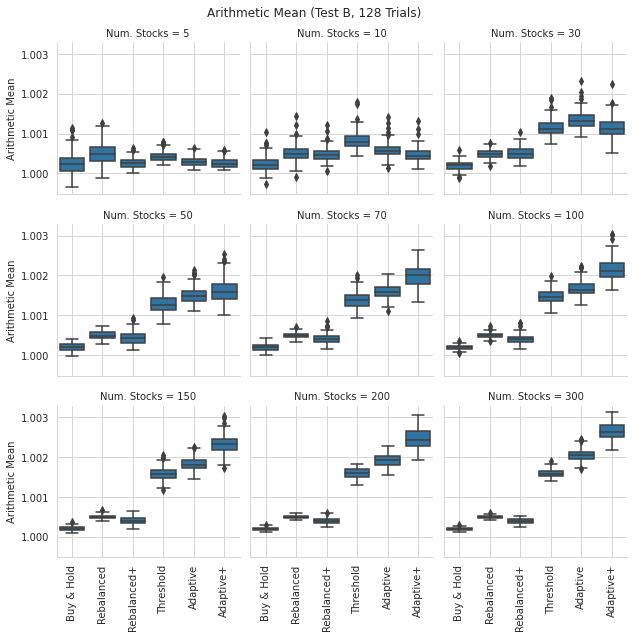

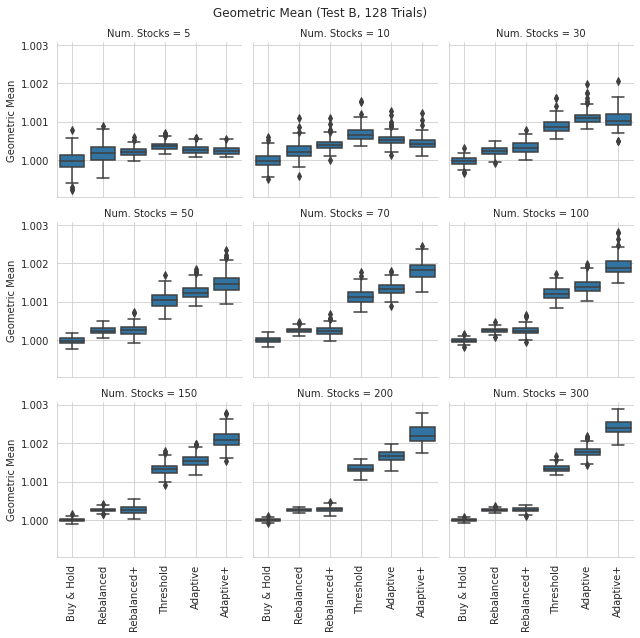

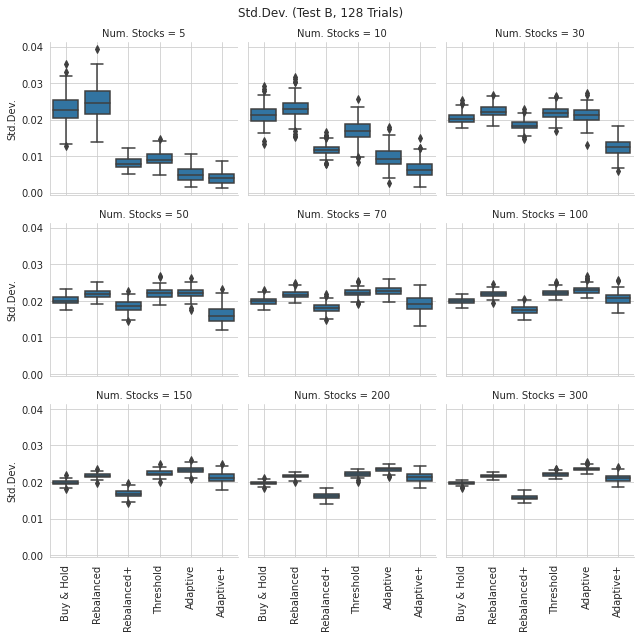

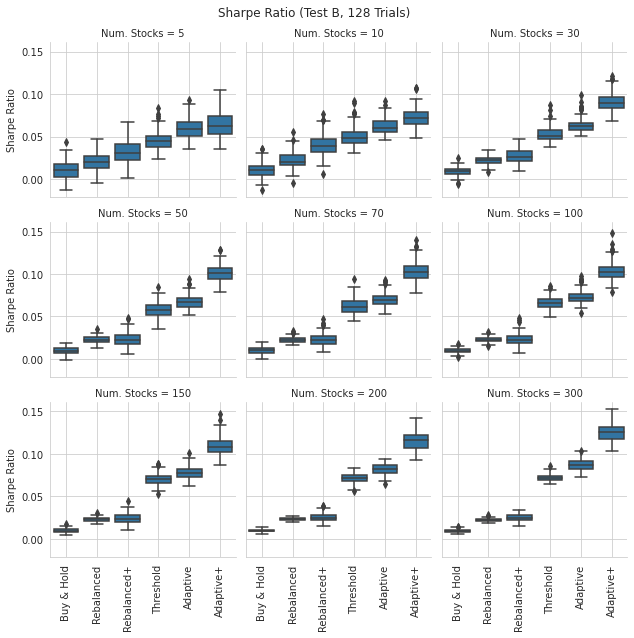

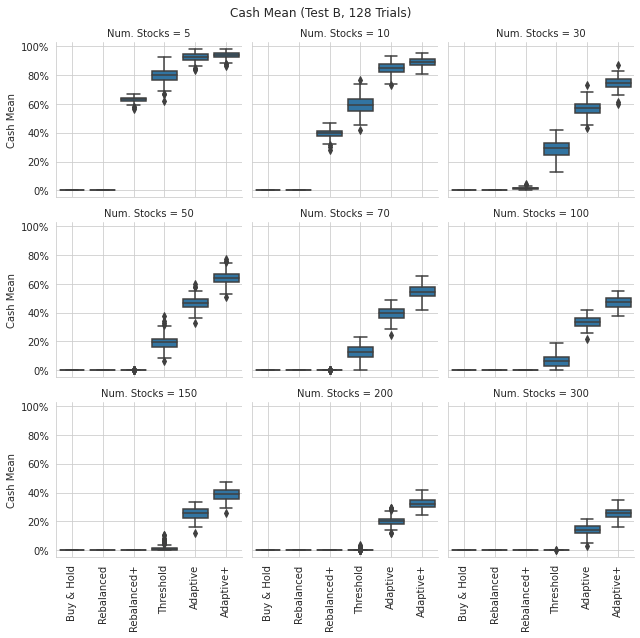

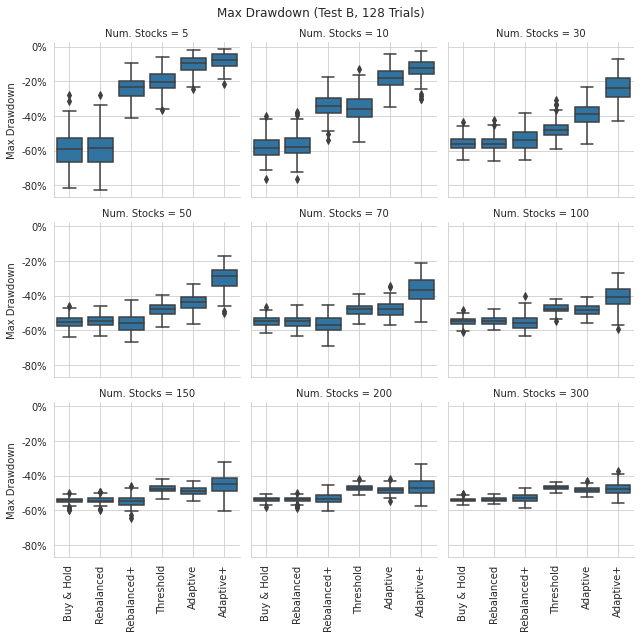

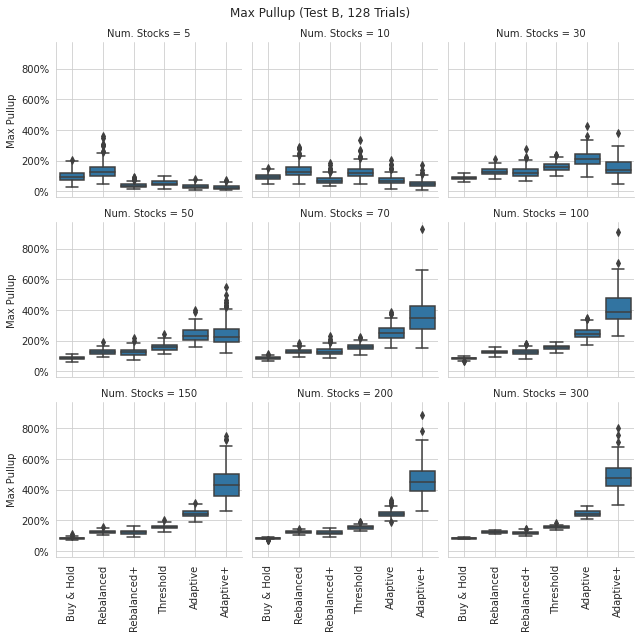

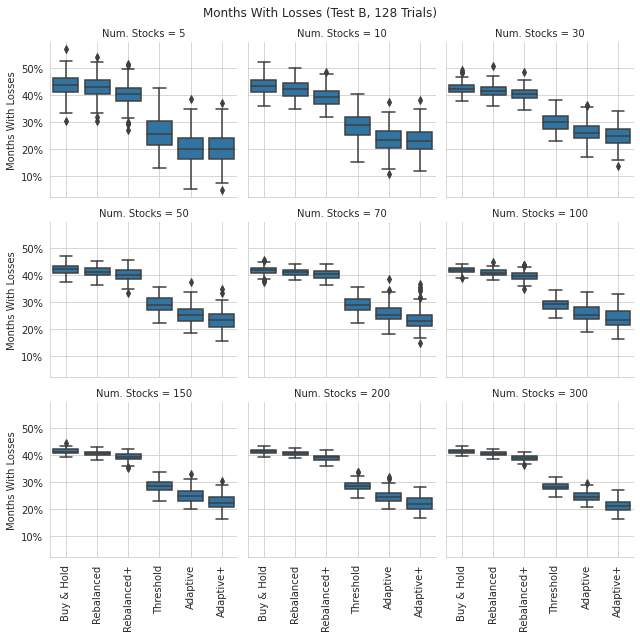

In [94]:
%%time
# Test B: Data Until 2010.
end_date = '2010-01-01'
sim_plot_all(test_name='Test B',
             returns=daily_returns[:end_date],
             future_returns=future_mean_ann_returns[:end_date],
             num_stocks=num_stocks, num_trials=num_trials,
             noise_scale_future_rets=0.0,
             func_adjust_corr=adjust_weights_corr,
             min_return=0.1, max_return=0.5,
             min_weight=0.0, max_weight=0.1)

## Test C - Data From 2010 (Omniscient)

In [ ]:
%%time
# Test C: Data From 2010.
start_date = '2010-01-01'
sim_plot_all(test_name='Test C',
             returns=daily_returns[start_date:],
             future_returns=future_mean_ann_returns[start_date:],
             num_stocks=num_stocks, num_trials=num_trials,
             noise_scale_future_rets=0.0,
             func_adjust_corr=adjust_weights_corr,
             min_return=0.1, max_return=0.5,
             min_weight=0.0, max_weight=0.1)

## Test D - Noisy Returns (Robustness)

In [ ]:
%%time
# Test D: Noisy Future Returns.
sim_plot_all(test_name='Test D',
             returns=daily_returns,
             future_returns=future_mean_ann_returns,
             num_stocks=num_stocks, num_trials=num_trials,
             noise_scale_future_rets=0.5,
             func_adjust_corr=adjust_weights_corr,
             min_return=0.1, max_return=0.5,
             min_weight=0.0, max_weight=0.1)

## Test E - Noisy Correlations (Robustness)

In [ ]:
# Arguments for the Adaptive+ robustness tests.
adp_args = dict(
    compare_pairs=adp_pairs, order=adp_order,
    use_bhold=False, use_thres=False,
    use_rebal=True, use_rebal_plus=False,
    use_adapt=True, use_adapt_plus=True,
    use_adp_corr_all=True, use_adp_corr_naive=True,
    use_adp_heavy_noise=True, use_adp_pure_noise=True,
    use_adp_corr_equal=True, use_adp_corr_invert=True)

In [ ]:
%%time
# Time-usage for this test is nearly 2 hours with this configuration,
# when run on a 4-core (8 thread) CPU with 2.6 GHz (3.5 GHz boost).

# Test E: Noisy Correlations.
sim_plot_all(test_name='Test E',
             returns=daily_returns,
             future_returns=future_mean_ann_returns,
             num_stocks=num_stocks, num_trials=num_trials,
             noise_scale_future_rets=0.0,
             min_return=0.1, max_return=0.5,
             min_weight=0.0, max_weight=0.1,
             **adp_args)

## Test F - Noisy Returns & Correlations (Robustness)

In [ ]:
%%time
# Test F: Noisy Returns AND Correlations.
sim_plot_all(test_name='Test F',
             returns=daily_returns,
             future_returns=future_mean_ann_returns,
             num_stocks=num_stocks, num_trials=num_trials,
             noise_scale_future_rets=0.5,
             min_return=0.1, max_return=0.5,
             min_weight=0.0, max_weight=0.1,
             **adp_args)

## Parameter Tuning

We will now tune the following parameters for the Adaptive portfolio when it only has 30 stocks: `min_return`, `max_return`, and `max_weight`. The parameter `min_weight` is always set to zero to match the paper. We want to maximize the Adaptive portfolio's mean daily return in excess of the Rebalanced portfolio, and we want to simultaneously minimize the Adaptive portfolio's Max Drawdown. These are two conflicting objectives so we are using a Multi-Objective Optimizer called NSGA-2 to obtain the so-called Pareto Front of mutually optimal solutions.

In [ ]:
class Problem:
    """
    Implements the problem that must be optimized in order to
    tune the parameters of a portfolio system. This defines a
    fitness function, search-space boundaries, and various configs.
    
    The fitness function essentially just takes 3 parameters:
    `min_return`, `max_return`, and `max_weight` which are passed
    to the function `sim_many_trials`, and then we calculate two
    performance statistics on the results and use those as the
    fitness objectives.
    """

    def __init__(self, **kwargs):
        """
        Create a new object instance.
        
        :param kwargs:
            Extra keyword-arguments to pass to `sim_many_trials`,
            such as `num_stocks` and `num_trials`.
        """
        # Copy args to self.
        self._kwargs = kwargs
        
        # Iteration counter.
        self._iteration = 0
        
    def fitness(self, params):
        """
        Calculate and return the fitness for the given parameters.
        
        :param params: List of parameters.
        :return: Fitness for the given parameters.
        """

        # Convert parameters to dict with named values.
        args = unpack_params(params=params)
        
        # Perform random portfolio simulations.
        # We only compute the portfolios we need to calculate
        # the fitness objectives. Especially the Adaptive+ is
        # very slow to compute so we should avoid doing that.
        df_stats, df_port_val = \
            sim_many_trials(use_bhold=False, use_thres=False,
                            use_rebal=True, use_rebal_plus=False,
                            use_adapt=True, use_adapt_plus=False,
                            **args, **self._kwargs)
        
        # Fitness objective 1:
        # Mean difference between the arith. mean daily return
        # for Adaptive and Rebalanced portfolios.
        ari_mean_dif = df_stats.loc[ADAPT, ARI_MEAN] - df_stats.loc[REBAL, ARI_MEAN]
        fitness1 = -np.mean(ari_mean_dif)

        # Fitness objective 2:
        # Mean Max Drawdown for all trials of the Adaptive portfolios.
        max_drawdown = df_stats.loc[ADAPT, MAX_DRAWDOWN]
        fitness2 = -np.mean(max_drawdown)

        # Note: The two fitness objectives are negated because
        # the optimizer is assuming minimization objectives.

        # Note: It seems that the two fitness objectives should
        # be calculated using the mean and not the median, because
        # the outliers are apparently important.
        
        # Print the iteration-number and the two fitness objectives.
        print(f'{self._iteration} \t {fitness1:.2e} \t {fitness2:.2e}           ')
        
        # Increase iteration counter.
        self._iteration += 1
        
        return [fitness1, fitness2]

    def get_bounds(self):
        """Get boundaries of the search-space."""
        # These are the lower and upper boundaries for the
        # search-space. The parameters are:
        # min_return, max_return_delta, max_weight
        # See the function `unpack_parameters` for the meaning.
        # Note that the delta-value must be greater than zero,
        # otherwise it may cause a division-by-zero in `linear_map`.
        lo = np.array([-0.2, 1e-5, 0.0])
        hi = np.array([ 1.0, 1.0, 1.0])
            
        return lo, hi

    def get_nobj(self):
        """Get number of fitness-objectives."""
        return 2

In [ ]:
def unpack_params(params):
    """
    Convert a list of parameters from the optimizer into a
    dict with arguments that can be passed to the function
    `sim_many_trials`.
    
    :param params: List with parameter-values.
    :return: Dict with named parameter-values.
    """
    # Unpack the parameter-values.
    (min_return, max_return_delta, max_weight) = params

    # Convert some of the parameters-values.
    max_return = min_return + max_return_delta
    
    # Create a dict that can be passed as argument to
    # the function `sim_many_trials`.
    args = dict(min_return=min_return, max_return=max_return,
                min_weight=0.0, max_weight=max_weight)

    return args

In [ ]:
def plot_pareto_front(best_fitness, test_name, num_stocks, num_trials,
                      list_idx=None, list_names=None):
    """
    Plot the so-called Pareto Front showing how well the optimal
    parameters performed on the two objectives.
    
    :param best_fitness:
        2-dim array of fitness-values for the two objectives.
        
    :param test_name:
        String with the experiment name.
        
    :param num_stocks:
        Integer with the number of stocks in the portfolios.
        
    :param num_trials:
        Integer with the number of trials with random portfolios.
        
    :return:
        Matplotlib Axis object.
    """

    # Get the fitness-values to plot. These are found by
    # multi-objective optimization so they are already
    # on the Pareto Front and they are also sorted.
    # Note the fitness-values are negated because the optimizer
    # did minimization but we are interested in maximization.
    fitness1 = -best_fitness[:, 0]
    fitness2 = -best_fitness[:, 1]
    
    # Create a single plot.
    fig = plt.figure(figsize=figsize_mid)
    ax = fig.add_subplot(211)

    # Plot dashed black line to indicate regions of loss vs. gain.
    ax.axvline(x=0.0, color='black', linestyle='dashed')
    
    # Plot the pareto-front as connected lines.
    ax.plot(fitness1, fitness2)

    # Plot dots to show the exact data-points.
    ax.scatter(fitness1, fitness2)

    # Plot red dots for selected data-points.
    if list_idx is not None and list_names is not None:
        # Offsets on x and y-axes for the names.
        offset1 = np.abs(np.mean(fitness1)) * 0.05
        offset2 = np.abs(np.mean(fitness2)) * 0.05
        
        # For each selected data-point.
        for idx, name in zip(list_idx, list_names):
            # Get the two fitness-values.
            f1 = fitness1[idx]
            f2 = fitness2[idx]
            
            # Plot red dot.
            ax.plot(f1, f2, marker='o', color='red')
            
            # Show the name next to the red dot.
            ax.text(f1 + offset1, f2 + offset2, name)

    # Set title and axis-labels.
    title = 'Pareto Front for Parameter Tuning ' + \
            f'({test_name}, {num_stocks} Stocks, {num_trials} Trials)'
    ax.set_title(title)
    ax.set_xlabel('Mean Excess Daily Return')
    ax.set_ylabel('Max Drawdown')
    
    # Convert axis-ticks to percentages and scientific format.
    ax.xaxis.set_major_formatter(sci_formatter1)
    ax.yaxis.set_major_formatter(pct_formatter0)

    # Show grid.
    ax.grid(True)

    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk.
    filename = f'{test_name} - Pareto Front for Parameter Tuning.svg'
    filename = os.path.join(path_plots, filename)
    fig.savefig(filename, bbox_inches='tight')

    return fig

In [ ]:
%%time
# Time-usage is about 1 hour 40 min with this configuration,
# when run on a 4-core (8 thread) CPU with 2.6 GHz (3.5 GHz boost).

# Experiment config.
num_stocks = 30
num_trials = 128
test_name = 'Test G'

# Common args for the function `sim_many_trials`.
sim_args = dict(num_stocks=num_stocks, num_trials=num_trials,
    returns=daily_returns, future_returns=future_mean_ann_returns)

# Create a problem-instance.
# When using noise in the future stock-returns, it causes the
# optimized parameters to become much more conservative, so only
# stocks that have very high returns can get into the portfolio.
# This causes a lot of the portfolio to be held in cash. So for
# small portfolio sizes e.g. 30 stocks we don't use noise here.
problem = Problem(noise_scale_future_rets=0.0, **sim_args)

# Create an NSGA-2 Multi-Objective optimizer.
optimizer = pg.algorithm(pg.nsga2(gen=20))

# Create a population of candidate solutions.
# We need a population of size at least 40, otherwise it seems to
# "collapse" and only find a small sub-set of the Pareto Front.
population = pg.population(prob=problem, size=40)

# Optimize the problem.
population = optimizer.evolve(population)

# Save the best-found parameters and fitnesses for later use.
best_parameters = population.get_x()
best_fitness = population.get_f()

# Sorted index for the fitnesses.
idx_sort = np.argsort(best_fitness[:, 0])

# Sort the best-found parameters and fitnesses.
best_parameters = best_parameters[idx_sort]
best_fitness = best_fitness[idx_sort]

In [ ]:
# Show the best parameters on the Pareto Front.
np.round(best_parameters, 2)

In [ ]:
%%time
# Get the best parameters with regard to the 2nd fitness measure
# which minimizes the Max Drawdown of the Adaptive portfolios.
idx1 = np.argmin(best_fitness[:,1])
best_args1 = unpack_params(best_parameters[idx1])
test_name1 = test_name + '-1'
display(best_args1)

# Use the selected parameters for simulating random portfolios.
df_stats, df_port_val = sim_many_trials(**sim_args, **best_args1)

# Plot comparison of all performance statistics.
plot_compare_stats_all(df_stats=df_stats, test_name=test_name1,
                       num_stocks=num_stocks, num_trials=num_trials);

In [ ]:
%%time
# Get the parameters where the Adaptive and Rebalanced portfolios
# have nearly the same mean daily return. But the Adaptive portfolios
# may have significantly better Max Drawdown because of the
# parameter tuning.
idx2 = np.argmin(np.abs(best_fitness[:,0]))
best_args2 = unpack_params(best_parameters[idx2])
test_name2 = test_name + '-2'
display(best_args2)

# Use the selected parameters for simulating random portfolios.
df_stats, df_port_val = sim_many_trials(**sim_args, **best_args2)

# Plot comparison of all performance statistics.
plot_compare_stats_all(df_stats=df_stats, test_name=test_name2,
                       num_stocks=num_stocks, num_trials=num_trials);

In [ ]:
%%time
# Get the best parameters with regard to the 1st fitness measure
# which maximizes the mean daily return of the Adaptive portfolios.
idx3 = np.argmin(best_fitness[:,0])
best_args3 = unpack_params(best_parameters[idx3])
test_name3 = test_name + '-3'
display(best_args3)

# Use the selected parameters when simulating random portfolios.
df_stats, df_port_val = sim_many_trials(**sim_args, **best_args3)

# Plot comparison of all performance statistics.
plot_compare_stats_all(df_stats=df_stats, test_name=test_name3,
                       num_stocks=num_stocks, num_trials=num_trials);

In [ ]:
# Indices and names to be highlighted in the Pareto plot.
list_idx = [idx1, idx2, idx3]
list_names = [test_name1, test_name2, test_name3]

In [ ]:
# Plot the Pareto Front with the best fitness values.
plot_pareto_front(best_fitness=best_fitness, test_name=test_name,
                  num_stocks=num_stocks, num_trials=num_trials,
                  list_idx=list_idx, list_names=list_names);